In [140]:
# Import relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
import time
from numpy import mean, std
from lime.lime_tabular import LimeTabularExplainer

# Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
)
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Raw data was obtained from kaggle 
# https://www.kaggle.com/datasets/nikhil1e9/loan-default/?select=Loan_default.csv

df = pd.read_csv("../../dataset/Loan_default.csv")

# 1: Business context
You are a Data Scientist that has been tasked with performing analytics and modelling for a loan default prediction  dataset.
The tasks included are; perform EDAs, model training and inference and any further analytics that are deem suitable. The model constructed should be stable, robust, and not susceptible to any drastic changes (i.e.. minor variations in one value that leads to different outcomes).

- Objective of the modelling:
  - Loan Default Assessment where the priority is for risk assessment - accurately assess the creditworthiness of potential loan borror.
- Metrics/Consideration for the model
  - Accuracy
  - ROC/AUC
  - Stability
  - Robustness
  - Sensitivity
  - Operational Cost
  - Interpretability
- Models Considered
  - Base Learners (Logistic Regression / Decision Tree)
  - Ensemble (LightGBM, Random Forest)
  - Neural Network (MLP)

# 2: Data Understanding - EDA

Using the dataset provided, the following will be done: 
- Understanding variables in the datasets
- Cleaning dataset
  - Removing redundant variables that may not be useful for modelling
  - data quality check (check for any columns that is imbalanced or have null/na values)
  - removing outliers (if any)
- Analysing relationships beten variables
  - Using visualisation and tables 
    - histogram, countplot, correlation matrix

Expected Outcome
- To provide an overview on the dataset, insights on the relationship beten the variables, and potential data prepreprocessing required for data preparation step.

Summary for EDA
1. There are 225,694 good loans and 29,653 loans defaulted.
2. The number of defaulted loans decreased as the age increases while the number of loans increases as the age increases.
3. Low income groups have the highest default rates (19% for income <40,000) but it seems like there are more loans on the higher end of the income groups.
4. Loans with credit scores from 200-300 have the highest default rates at 15.5% while loans with credit scores in the range of 800-900 will have significantly lesser default rates at 9.8%.
5. The default rate seems to be increasing as the number of credit lines increases with the highest default rate at 12.9% for 4 credit lines and 10.5% for borrowers with 1 credit line.
6. Most loans have <10% interest rate (34.8%) and they have the lowest default rate at 7% while the highest interest rate range (20% - 25%) have 10% more default rates at 17.8% compared to loans with <10% insterest rates.
7. Loans with DTI Ratio from 0.6 - 1.0 have the highest default rates is at 12%.

## 2.1 Data Exploration

In [3]:
df

LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0       I38PQUQS96   56   85994       50587          520              80   
1       HPSK72WA7R   69   50432      124440          458              15   
2       C1OZ6DPJ8Y   46   84208      129188          451              26   
3       V2KKSFM3UN   32   31713       44799          743               0   
4       EY08JDHTZP   60   20437        9139          633               8   
...            ...  ...     ...         ...          ...             ...   
255342  8C6S86ESGC   19   37979      210682          541             109   
255343  98R4KDHNND   32   51953      189899          511              14   
255344  XQK1UUUNGP   56   84820      208294          597              70   
255345  JAO28CPL4H   42   85109       60575          809              40   
255346  ZTH91CGL0B   62   22418       18481          636             113   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0                    4         15.23        36      0.44   Bachelor's   
1                    1          4.81        60      0.68     Master's   
2                    3         21.17        24      0.31     Master's   
3                    3          7.07        24      0.23  High School   
4                    4          6.51        48      0.73   Bachelor's   
...                ...           ...       ...       ...          ...   
255342               4         14.11        12      0.85   Bachelor's   
255343               2         11.55        24      0.21  High School   
255344               3          5.29        60      0.50  High School   
255345               1         20.90        48      0.44  High School   
255346               2          6.73        12      0.48   Bachelor's   

       EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0           Full-time      Divorced         Yes           Yes       Other   
1           Full-time       Married          No            No       Other   
2          Unemployed      Divorced         Yes           Yes        Auto   
3           Full-time       Married          No            No    Business   
4          Unemployed      Divorced          No           Yes        Auto   
...               ...           ...         ...           ...         ...   
255342      Full-time       Married          No            No       Other   
255343      Part-time      Divorced          No            No        Home   
255344  Self-employed       Married         Yes           Yes        Auto   
255345      Part-time        Single         Yes           Yes       Other   
255346     Unemployed      Divorced         Yes            No   Education   

       HasCoSigner  Default  
0              Yes        0  
1              Yes        0  
2               No        1  
3               No        0  
4               No        0  
...            ...      ...  
255342          No        0  
255343          No        1  
255344         Yes        0  
255345          No        0  
255346         Yes        0  

[255347 rows x 18 columns]

In [4]:
df.shape

(255347, 18)

Note: There are 255,347 rows with 18 columns/features (17 independent and 1 dependent variable)

In [5]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

Note: It seems like there are 9 numerical features and 8 categorical features (excluding Default/dependent variable)

In [6]:
# Check for number of unique values for each variable
df.nunique(axis=0)

LoanID            255347
Age                   52
Income            114620
LoanAmount        158729
CreditScore          550
MonthsEmployed       120
NumCreditLines         4
InterestRate        2301
LoanTerm               5
DTIRatio              81
Education              4
EmploymentType         4
MaritalStatus          3
HasMortgage            2
HasDependents          2
LoanPurpose            5
HasCoSigner            2
Default                2
dtype: int64

## 2.2 Check for missing or null values

In [7]:
# Check for null values
df.isnull().any()

LoanID            False
Age               False
Income            False
LoanAmount        False
CreditScore       False
MonthsEmployed    False
NumCreditLines    False
InterestRate      False
LoanTerm          False
DTIRatio          False
Education         False
EmploymentType    False
MaritalStatus     False
HasMortgage       False
HasDependents     False
LoanPurpose       False
HasCoSigner       False
Default           False
dtype: bool

In [8]:
# Check for missing values
df.isna().any()

LoanID            False
Age               False
Income            False
LoanAmount        False
CreditScore       False
MonthsEmployed    False
NumCreditLines    False
InterestRate      False
LoanTerm          False
DTIRatio          False
Education         False
EmploymentType    False
MaritalStatus     False
HasMortgage       False
HasDependents     False
LoanPurpose       False
HasCoSigner       False
Default           False
dtype: bool

Note: Seems like the data has no missing value or nan value in the dataset.

## 2.3 Statistical Summary of the dataset

In [9]:
# NOTE: The apply suppresses scientific notation (i.e. returns regular numeric format)
df.describe().apply(lambda s: s.apply(lambda x: format(x, "f"))).transpose()

count           mean           std           min  \
Age             255347.000000      43.498306     14.990258     18.000000   
Income          255347.000000   82499.304597  38963.013729  15000.000000   
LoanAmount      255347.000000  127578.865512  70840.706142   5000.000000   
CreditScore     255347.000000     574.264346    158.903867    300.000000   
MonthsEmployed  255347.000000      59.541976     34.643376      0.000000   
NumCreditLines  255347.000000       2.501036      1.117018      1.000000   
InterestRate    255347.000000      13.492773      6.636443      2.000000   
LoanTerm        255347.000000      36.025894     16.969330     12.000000   
DTIRatio        255347.000000       0.500212      0.230917      0.100000   
Default         255347.000000       0.116128      0.320379      0.000000   

                         25%            50%            75%            max  
Age                31.000000      43.000000      56.000000      69.000000  
Income          48825.500000   82466.000000  116219.000000  149999.000000  
LoanAmount      66156.000000  127556.000000  188985.000000  249999.000000  
CreditScore       437.000000     574.000000     712.000000     849.000000  
MonthsEmployed     30.000000      60.000000      90.000000     119.000000  
NumCreditLines      2.000000       2.000000       3.000000       4.000000  
InterestRate        7.770000      13.460000      19.250000      25.000000  
LoanTerm           24.000000      36.000000      48.000000      60.000000  
DTIRatio            0.300000       0.500000       0.700000       0.900000  
Default             0.000000       0.000000       0.000000       1.000000

## 2.4 Exploratory Data Analysis

### 2.4.1 EDA - Target Variable

In [10]:
# Check the count for target variable
df["Default"].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

Default
0    225694
1     29653
Name: count, dtype: int64


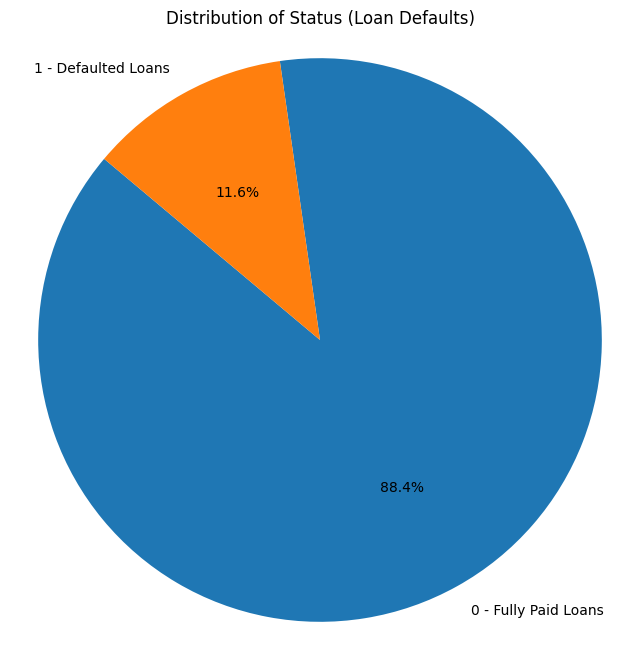

In [11]:
# Calculate the value counts for the categorical column
default_counts = df["Default"].value_counts()
# Rename the index for readability in pie chart
print(default_counts)
mapping = {0: "0 - Fully Paid Loans", 1: "1 - Defaulted Loans"}
default_counts.index = default_counts.index.map(mapping)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(default_counts, labels=default_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Status (Loan Defaults)")
plt.axis("equal")  # Equal aspect ratio ensures that the pie chart is circular.

# Show the pie chart
plt.show()

Note: This indicates that the dataset is an imbalanced dataset where the defaulted loans is less than 12% of the records. The dataset may require further preprocessing later (resampling) before modelling.

### 2.4.2 EDA - Categorical Variables

In [12]:
def get_countplot_by_default(feature: str, df: pd.DataFrame):
    """
    Generate a count plot of a categorical feature grouped by the 'Default' column.

    Args:
        feature (str): The name of the categorical feature to be plotted.
        df (pd.DataFrame): The input DataFrame containing the data to be plotted.

    Returns:
        None
    """
    value_counts_df = (
        df.groupby([feature, "Default"])
        # Compute group size
        .size()
        # Turn index into columns
        .unstack("Default")
        # Assign subtotal and percentage col
        .assign(total=lambda data: data.loc[:, -2:].sum(axis=1))
        # Assign the default rate for particular category/class
        .assign(default_rate=lambda data: round(data[1] / data["total"] * 100, 2))
        .assign(
            percentage_from_total=lambda data: round(
                data["total"] / data["total"].sum() * 100, 2
            )
        )
        .sort_values("percentage_from_total", ascending=False)
    )
    print(value_counts_df)

    # Sort by the feature
    df = df.sort_values(by=[feature])

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x=feature, ax=ax, hue="Default", data=df)
    # Rotate xaxis for variables with more unique values
    if feature in ["purpose", "state_2d"]:
        plt.xticks(rotation=90)
    plt.show()

Default          0     1  total  default_rate  percentage_from_total
Education                                                           
Bachelor's   56577  7789  64366         12.10                  25.21
High School  55673  8230  63903         12.88                  25.03
Master's     56633  6908  63541         10.87                  24.88
PhD          56811  6726  63537         10.59                  24.88


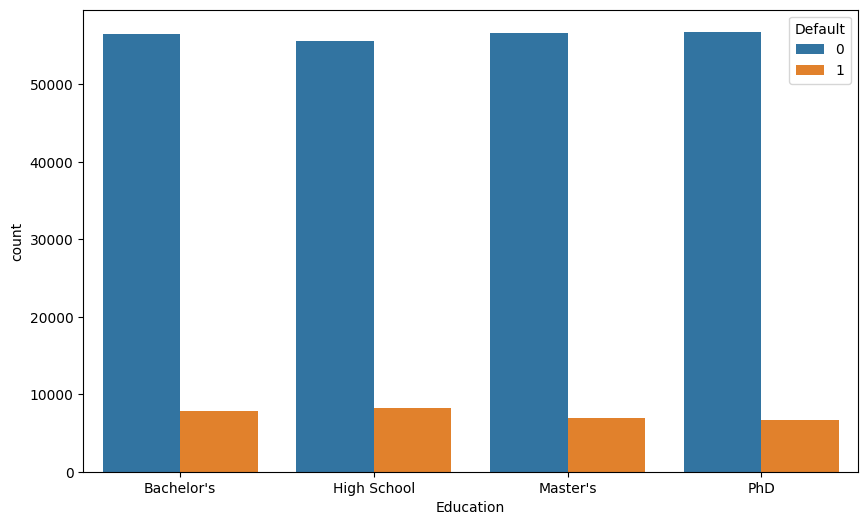

In [14]:
get_countplot_by_default(feature="Education", df=df)

Note: The type of education for the loan borrower seems to be consistent at ~25% for each loan term with similar default rate (10% - 12%) for each category as well

Default             0     1  total  default_rate  percentage_from_total
EmploymentType                                                         
Part-time       56484  7677  64161         11.97                  25.13
Unemployed      55174  8650  63824         13.55                  25.00
Self-employed   56404  7302  63706         11.46                  24.95
Full-time       57632  6024  63656          9.46                  24.93


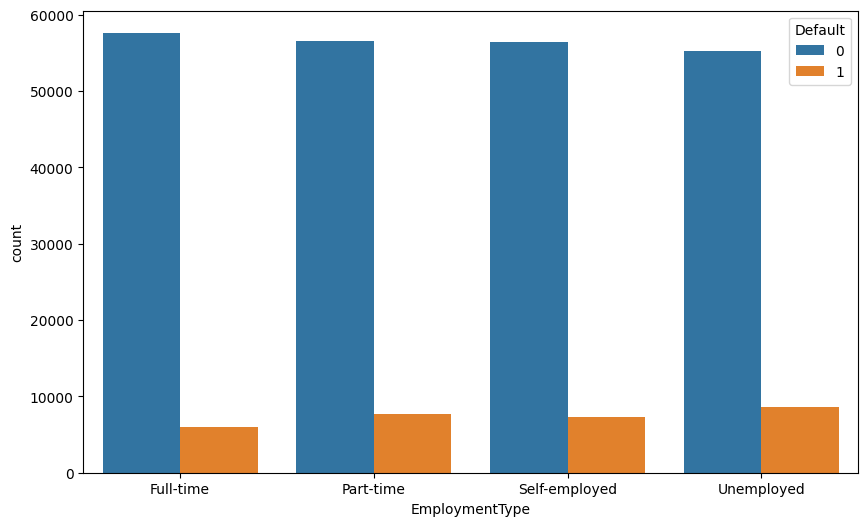

In [15]:
get_countplot_by_default(feature="EmploymentType", df=df)

Default            0      1  total  default_rate  percentage_from_total
MaritalStatus                                                          
Married        76433   8869  85302         10.40                  33.41
Divorced       74376  10657  85033         12.53                  33.30
Single         74885  10127  85012         11.91                  33.29


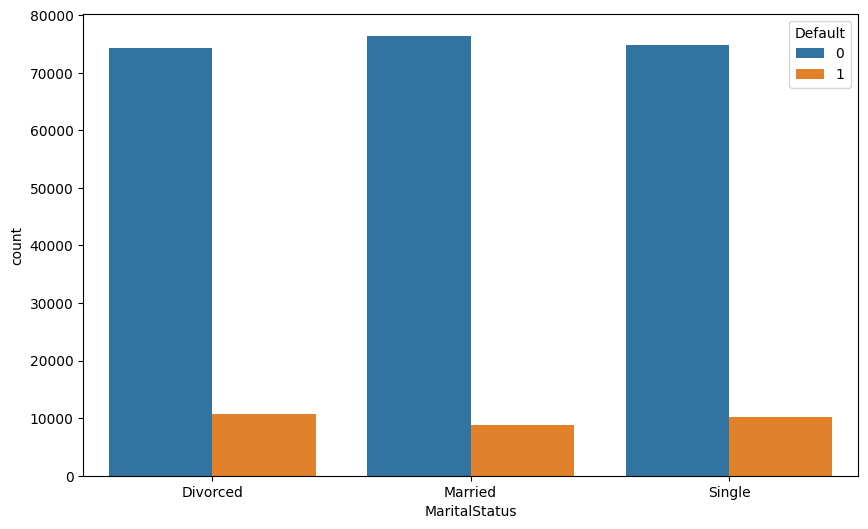

In [16]:
get_countplot_by_default(feature="MaritalStatus", df=df)

Note: Divorced borrower seems to have slightly higher default rate at 12.5% followed by Single (11.9%) and Married (10.4%)

Default             0      1   total  default_rate  percentage_from_total
HasDependents                                                            
Yes            114326  13416  127742         10.50                  50.03
No             111368  16237  127605         12.72                  49.97


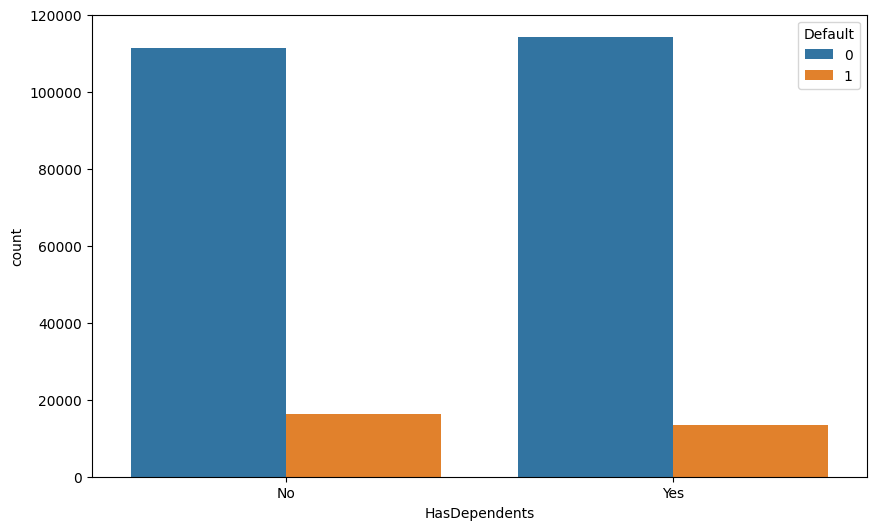

In [17]:
get_countplot_by_default(feature="HasDependents", df=df)

Note: Those without dependents seems to have slightly higher default rate at 12.7% compared to the borrowers with dependents (10.5%)

Default          0     1  total  default_rate  percentage_from_total
LoanPurpose                                                         
Business     44975  6323  51298         12.33                  20.09
Home         46037  5249  51286         10.23                  20.08
Education    44967  6038  51005         11.84                  19.97
Other        44912  6002  50914         11.79                  19.94
Auto         44803  6041  50844         11.88                  19.91


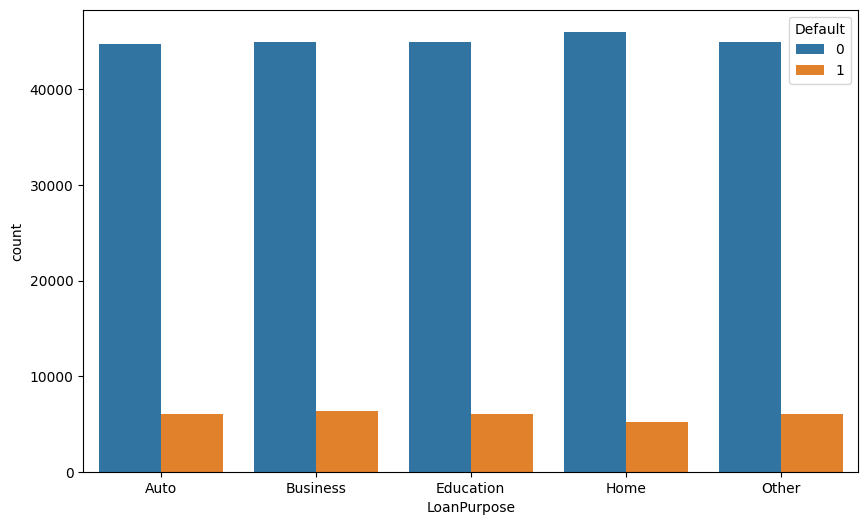

In [18]:
get_countplot_by_default(feature="LoanPurpose", df=df)

Note: Loans for "Home" have the least default rate at 10.2% only 

Default           0      1   total  default_rate  percentage_from_total
HasCoSigner                                                            
Yes          114471  13230  127701         10.36                  50.01
No           111223  16423  127646         12.87                  49.99


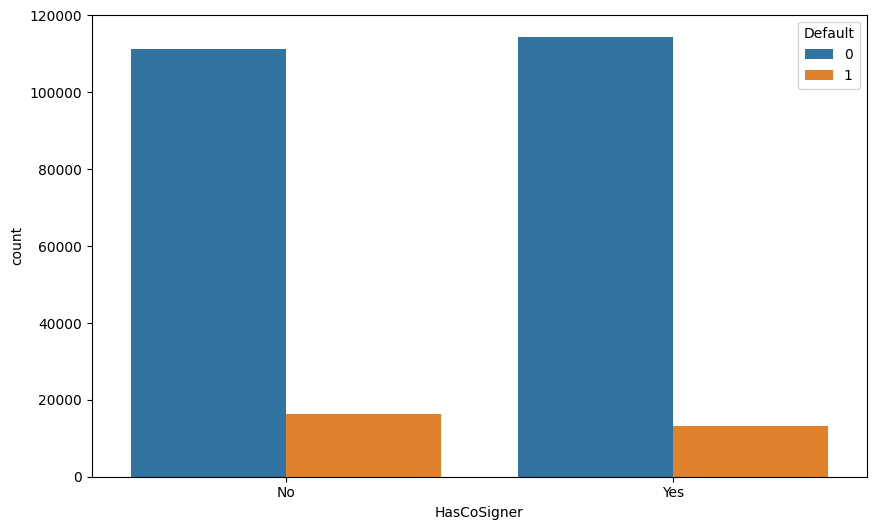

In [19]:
get_countplot_by_default(feature="HasCoSigner", df=df)

Note: Loans with no cosigners have higher tendency to default (12.9%)

Note: Overall categorical variables seems to have balanced number of samples across different classes

### 2.4.3 EDA - Numerical Variables

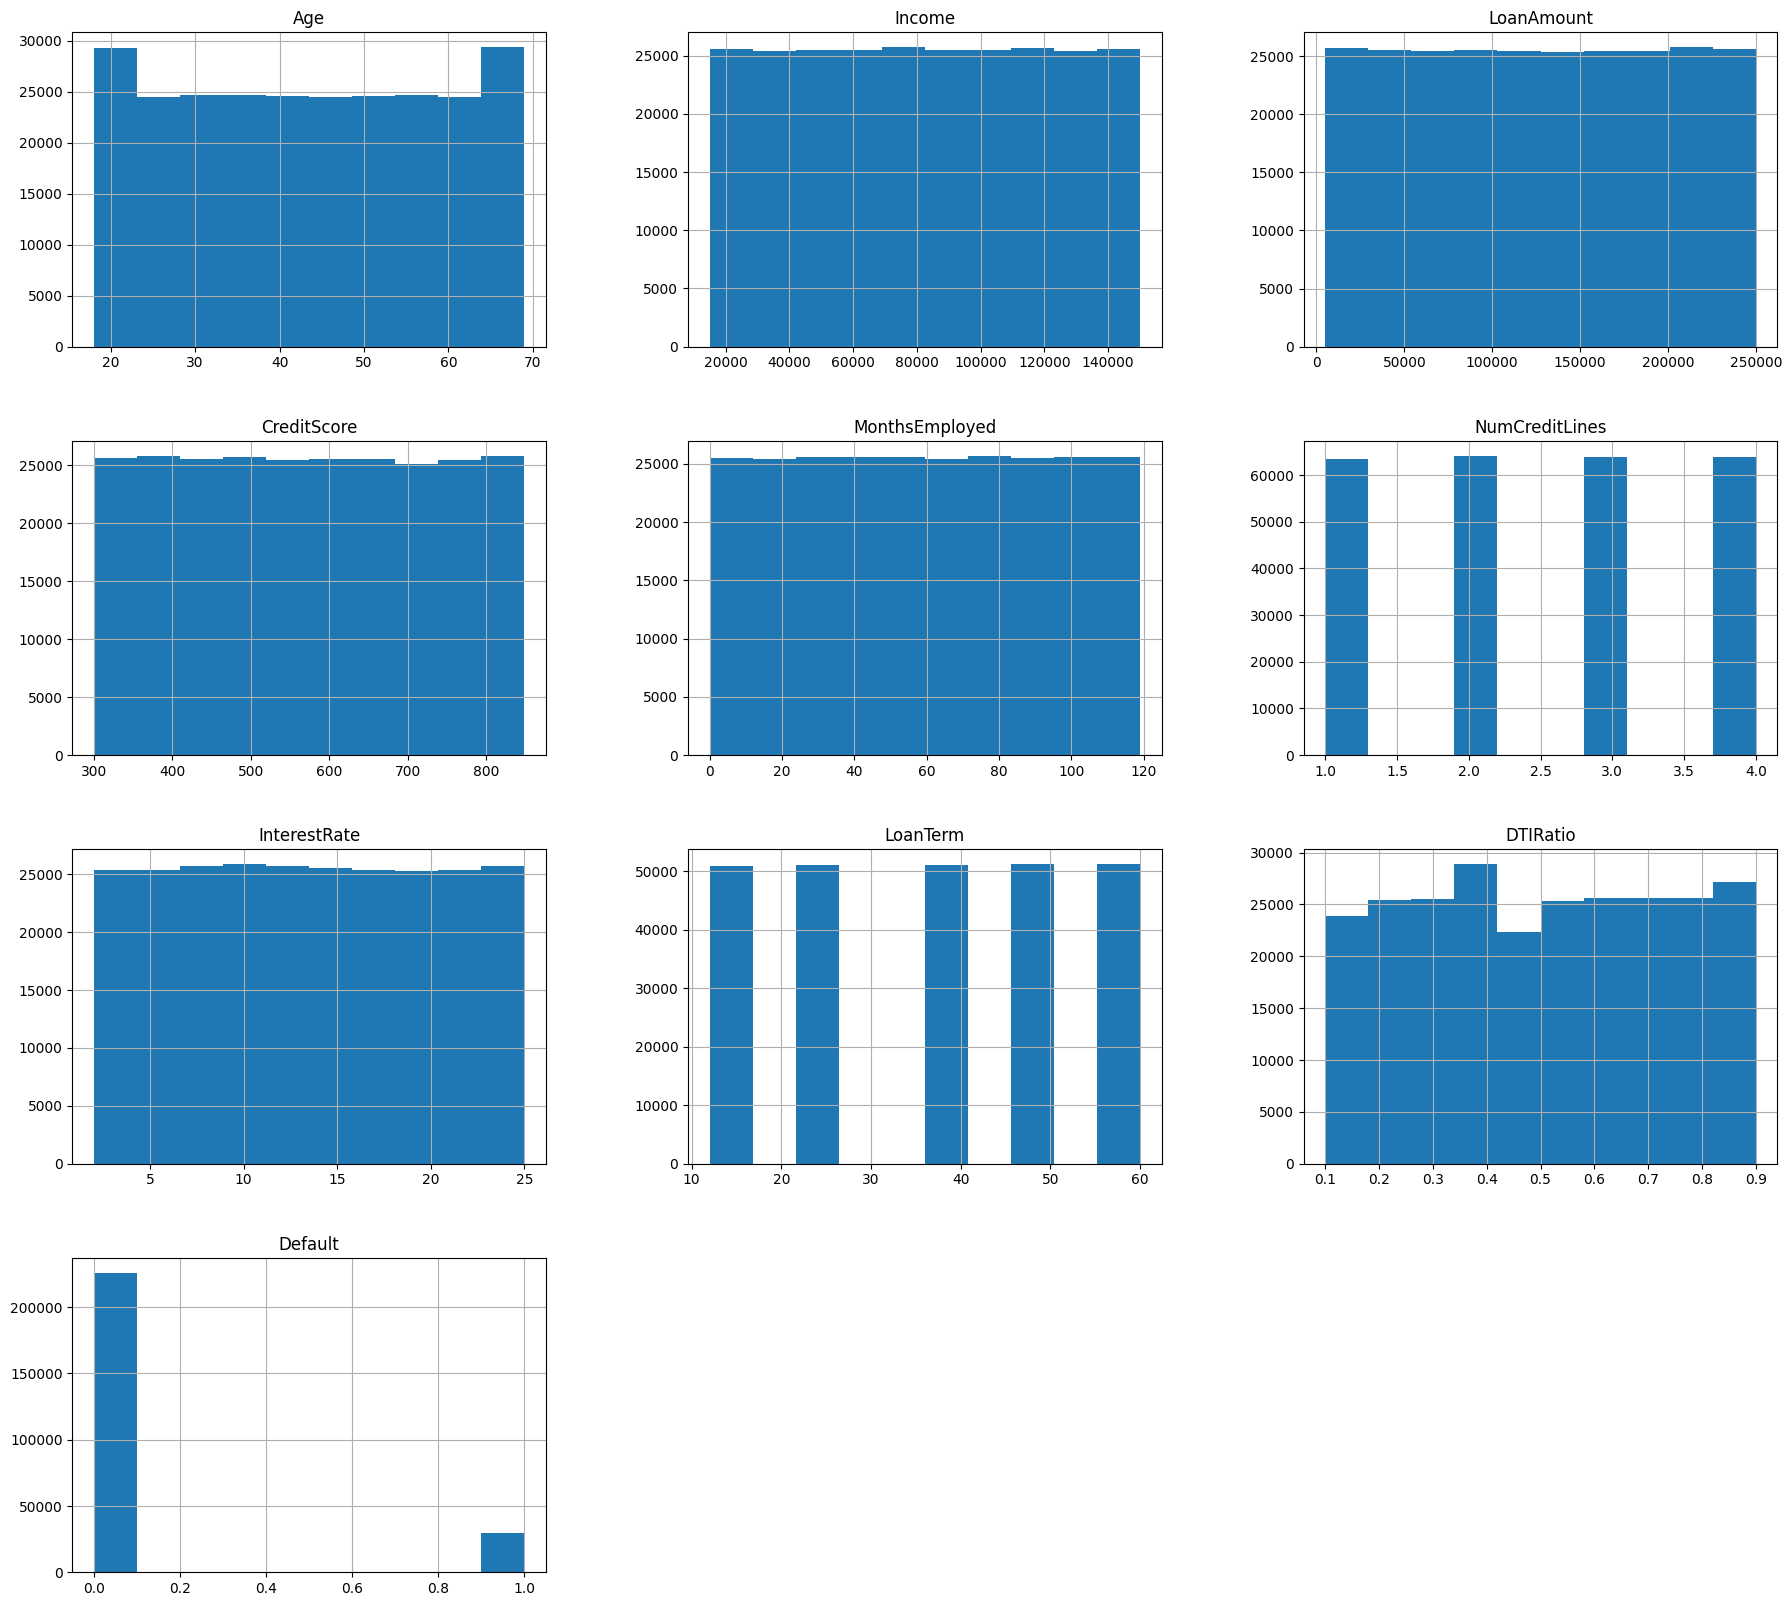

In [21]:
# Visualise all numeric variables in histogram
df.hist(figsize=(22, 20))
plt.show()

Note: There is no unusal values (i.e. negative values ) especially for the financial-related variables but it seems like the dataset have similar distribution with the categorical variables where the number of rows are evenly spread across each values. 

In [22]:
def get_hist_by_default(feature: str, df: pd.DataFrame, bins: List[int] = "auto", kde: bool = False):
    """
    Generate histograms and statistics for a specified feature by "Default"

    Args:
        feature (str): The feature column name for which to generate histograms.
        df (pd.DataFrame): The DataFrame containing the data.
        bins (List[int], optional): The specification for histogram bins. 
            This can be a list of bin edges or the string "auto" for automatic binning.
        kde (bool, optional): Whether to plot a kernel density estimate (KDE) along with the histogram.

    Returns:
        None
    """
    value_counts_df = (
        df.groupby([feature, "Default"])
        # Compute group size
        .size()
        # Turn index into columns
        .unstack("Default")
        # Assign subtotal and percentage col
        .assign(total=lambda data: data.loc[:, -2:].sum(axis=1))
        # Assign the default rate for particular category/class
        .assign(default_rate=lambda data: round(data[1] / data["total"] * 100, 2))
        .assign(
            percentage_from_total=lambda data: round(
                data["total"] / data["total"].sum() * 100, 2
            )
        )
        .sort_values("percentage_from_total", ascending=False)
    )
    # Sort by the categorical values
    sorted_df = df.sort_values(by=[feature])
    print(value_counts_df)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(x=feature, ax=ax, hue="Default", data=sorted_df, bins=bins, kde=kde)
    # # Rotate xaxis for variables with more unique values
    # if feature in [x, y]:
    #     plt.xticks(rotation=90)
    plt.show()

Default     0     1  total  default_rate  percentage_from_total
Age                                                            
40       4483   573   5056         11.33                   1.98
55       4721   343   5064          6.77                   1.98
33       4277   745   5022         14.83                   1.97
65       4736   291   5027          5.79                   1.97
53       4666   344   5010          6.87                   1.96
62       4730   269   4999          5.38                   1.96
32       4188   781   4969         15.72                   1.95
39       4402   571   4973         11.48                   1.95
34       4278   709   4987         14.22                   1.95
61       4716   266   4982          5.34                   1.95
22       3870  1100   4970         22.13                   1.95
45       4500   485   4985          9.73                   1.95
19       3867  1096   4963         22.08                   1.94
43       4456   509   4965         10.25

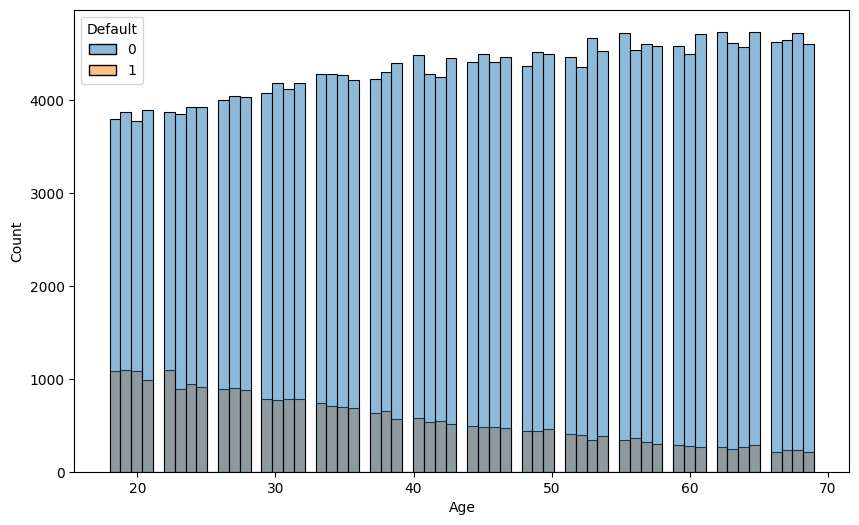

In [23]:
get_hist_by_default(feature="Age", df=df)

Note: The number of defaulted loans decreased as the age increases while the number of loans increases as the age increases

Default    0    1  total  default_rate  percentage_from_total
Income                                                       
15000    3.0  NaN    3.0           NaN                    0.0
105012   2.0  NaN    2.0           NaN                    0.0
105026   1.0  NaN    1.0           NaN                    0.0
105025   1.0  NaN    1.0           NaN                    0.0
105024   2.0  NaN    2.0           NaN                    0.0
...      ...  ...    ...           ...                    ...
60065    2.0  NaN    2.0           NaN                    0.0
60064    2.0  NaN    2.0           NaN                    0.0
60063    2.0  NaN    2.0           NaN                    0.0
60062    2.0  1.0    3.0         33.33                    0.0
149999   2.0  NaN    2.0           NaN                    0.0

[114620 rows x 5 columns]


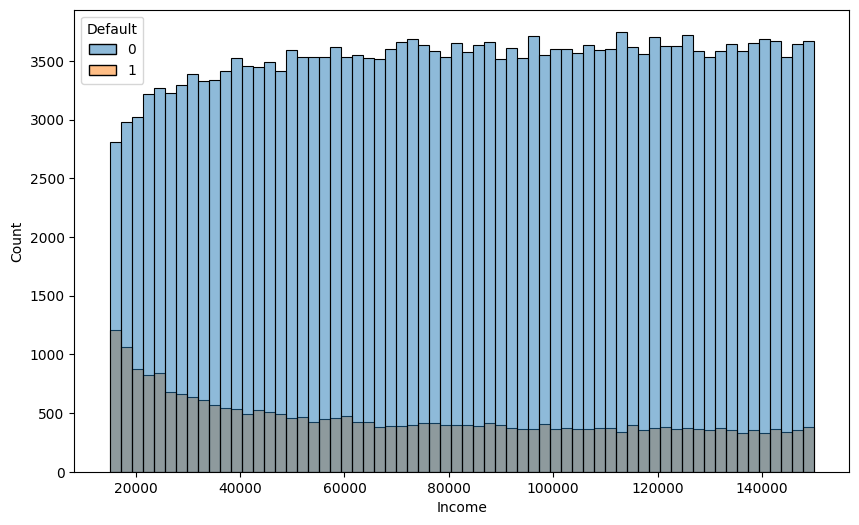

In [24]:
get_hist_by_default(feature="Income", df=df)

/tmp/ipykernel_13965/968589114.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([feature, "Default"])


Default               0     1  total  default_rate  percentage_from_total
bin                                                                      
(80000, 120000]   68569  7180  75749          9.48                  29.67
(40000, 80000]    67343  8368  75711         11.05                  29.65
(120000, 160000]  51528  5115  56643          9.03                  22.18
(0, 40000]        38254  8990  47244         19.03                  18.50
(160000, 200000]      0     0      0           NaN                   0.00


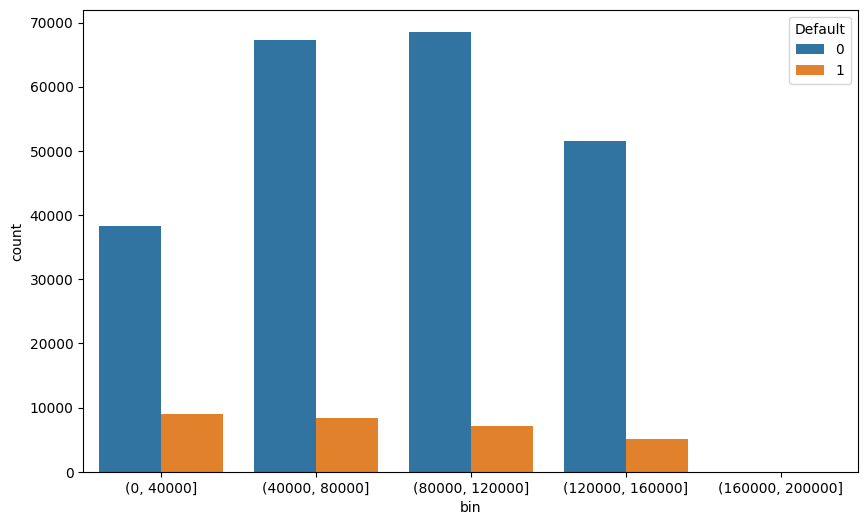

In [25]:
# Binning the income groups to 5 groups
start = 0
end = 200000
bin_width = 40000
income_bins = list(range(start, end + 1, bin_width))

income_df = df.copy()
income_df["bin"] = pd.cut(income_df["Income"], income_bins)


get_countplot_by_default(feature="bin", df=income_df)

Note: Similarly, the number of defaulted loans are the highest for the low income groups but it seems like there are more borrowers on the higher end of the income groups. The lower income groups (<40000) have the highest default rate at 19%. 

/tmp/ipykernel_13965/968589114.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([feature, "Default"])


Default          0     1  total  default_rate  percentage_from_total
bin                                                                 
(300, 400]   40448  6200  46648         13.29                  18.27
(500, 600]   40958  5484  46442         11.81                  18.19
(600, 700]   41262  5190  46452         11.17                  18.19
(400, 500]   40709  5666  46375         12.22                  18.16
(700, 800]   41169  4777  45946         10.40                  17.99
(800, 900]   20739  2261  23000          9.83                   9.01
(200, 300]     409    75    484         15.50                   0.19
(900, 1000]      0     0      0           NaN                   0.00


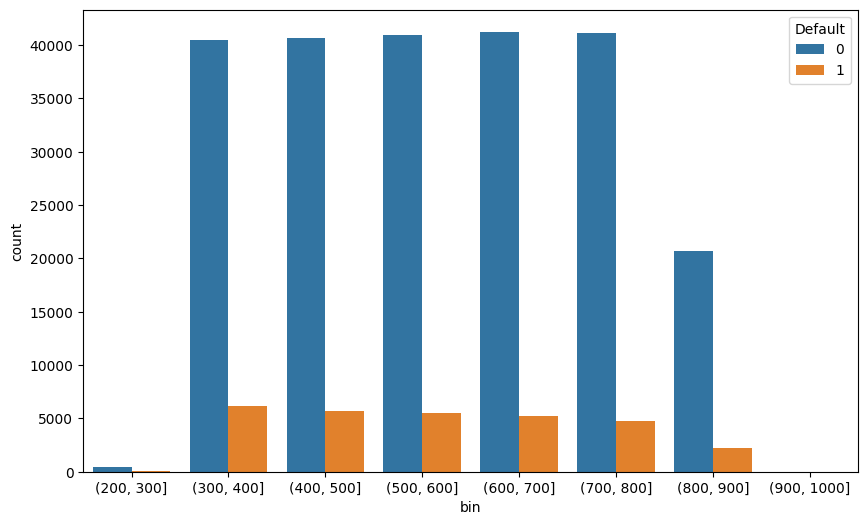

In [27]:
# Bin the credit scores for better visuals
creditscore_bins = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
creditscore_df = df.copy()
creditscore_df["bin"] = pd.cut(creditscore_df["CreditScore"], creditscore_bins)


get_countplot_by_default(feature="bin", df=creditscore_df)

Note: By binning the credit scores, it seems like credit scores from 200-300 have the highest default rates at 15.5% while credit scores at 800-900 will have significantly lesser default rates at 9.8%

Default             0     1  total  default_rate  percentage_from_total
NumCreditLines                                                         
2               57038  7092  64130         11.06                  25.11
3               56222  7612  63834         11.92                  25.00
4               55568  8261  63829         12.94                  25.00
1               56866  6688  63554         10.52                  24.89


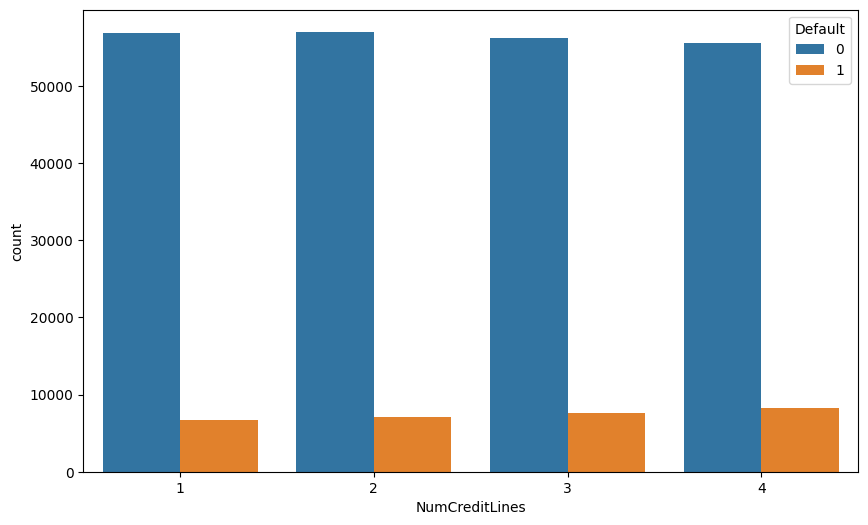

In [29]:
get_countplot_by_default(feature="NumCreditLines", df=df)

Note: The default rate seems to be increasing as the number of credit lines increases with the highest default rate at 12.9% for 4 credit lines and 10.5% for borrowers with 1 credit line

Default         0   1  total  default_rate  percentage_from_total
InterestRate                                                     
14.92         130  17    147         11.56                   0.06
2.25          134  10    144          6.94                   0.06
13.50         103  14    117         11.97                   0.05
10.21         119  15    134         11.19                   0.05
19.73          94  23    117         19.66                   0.05
...           ...  ..    ...           ...                    ...
3.55           81   4     85          4.71                   0.03
24.06          71  17     88         19.32                   0.03
13.49          80   9     89         10.11                   0.03
2.00           42   2     44          4.55                   0.02
25.00          44   9     53         16.98                   0.02

[2301 rows x 5 columns]


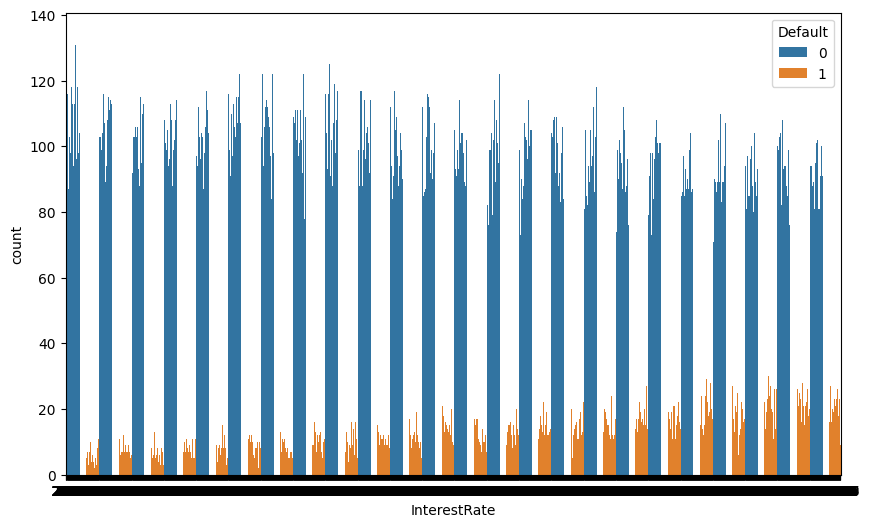

In [30]:
get_countplot_by_default(feature="InterestRate", df=df)

/tmp/ipykernel_13965/968589114.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([feature, "Default"])


Default                     0     1  total  default_rate  \
interest_rate_category                                     
<10%                    82668  6283  88951          7.06   
10%-15%                 50035  5899  55934         10.55   
20%-25%                 45597  9887  55484         17.82   
15%-20%                 47394  7584  54978         13.79   

Default                 percentage_from_total  
interest_rate_category                         
<10%                                    34.84  
10%-15%                                 21.91  
20%-25%                                 21.73  
15%-20%                                 21.53  


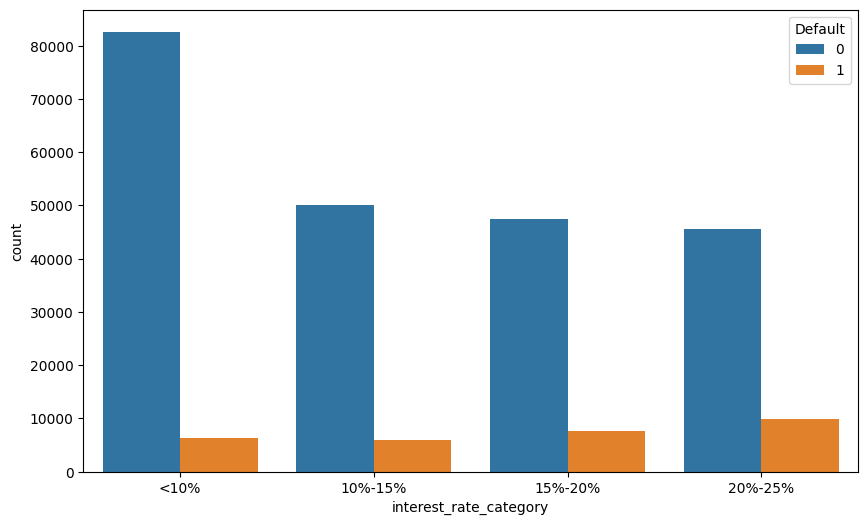

In [31]:
# Bin the credit scores for better visuals
# Create a copy of the DataFrame to avoid modifying the original df
interestrate_data = df.copy()
# Define the labels for the bins
bin_labels = ["<10%", "10%-15%", "15%-20%", "20%-25%"]
bin_edges = [0, 10, 15, 20, 25]
# Create a new column with the binned categories
interestrate_data["interest_rate_category"] = pd.cut(
    interestrate_data["InterestRate"], bins=bin_edges, labels=bin_labels
)

get_countplot_by_default(feature="interest_rate_category", df=interestrate_data)

Note: Most loans have <10% interest rate (34.8%) and they have the lowest default rate at 7% while the highest interest rate range (20% - 25%) have 10% more default rates at 17.8% compared to the lowest default rate

Default       0     1  total  default_rate  percentage_from_total
LoanTerm                                                         
48        45244  5922  51166         11.57                  20.04
60        45171  5983  51154         11.70                  20.03
36        45154  5907  51061         11.57                  20.00
24        45088  5921  51009         11.61                  19.98
12        45037  5920  50957         11.62                  19.96


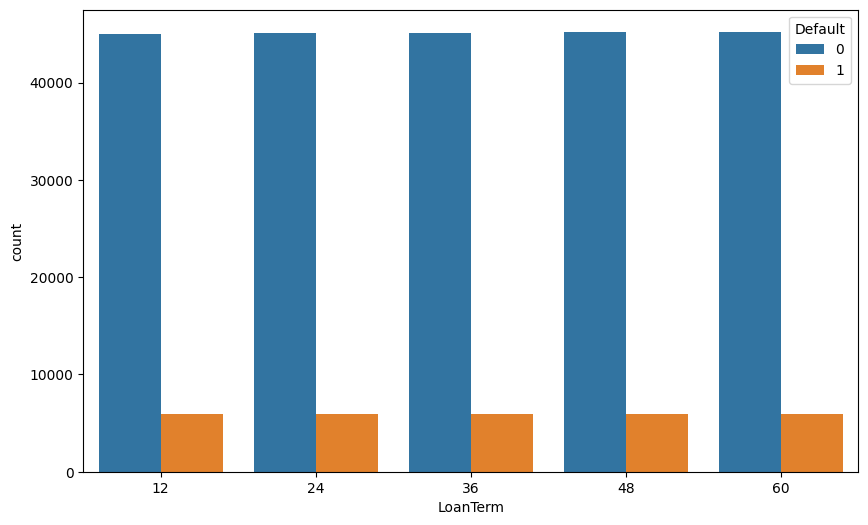

In [33]:
get_countplot_by_default(feature="LoanTerm", df=df)

Note: Regardless of loan term, it seems like the default rates are similar at 11%

/tmp/ipykernel_13965/968589114.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([feature, "Default"])


Default         0     1  total  default_rate  percentage_from_total
bin                                                                
(0.6, 0.8]  56149  7830  63979         12.24                  25.06
(0.2, 0.4]  56727  7129  63856         11.16                  25.01
(0.4, 0.6]  56119  7525  63644         11.82                  24.92
(0.0, 0.2]  30040  3473  33513         10.36                  13.12
(0.8, 1.0]  26659  3696  30355         12.18                  11.89


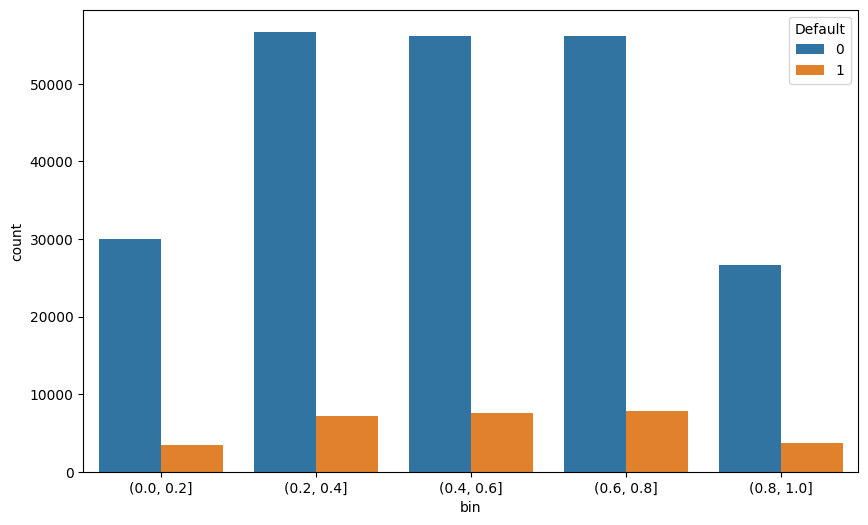

In [36]:
# Bin the credit scores for better visuals
dtiratio_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
dtiratio_df = df.copy()
dtiratio_df["bin"] = pd.cut(dtiratio_df["DTIRatio"], dtiratio_bins)


get_countplot_by_default(feature="bin", df=dtiratio_df)

Note: The highest default rates is at 12% within the DTI Ratio from 0.6 - 1.0.

### 2.5 Correlation Analysis

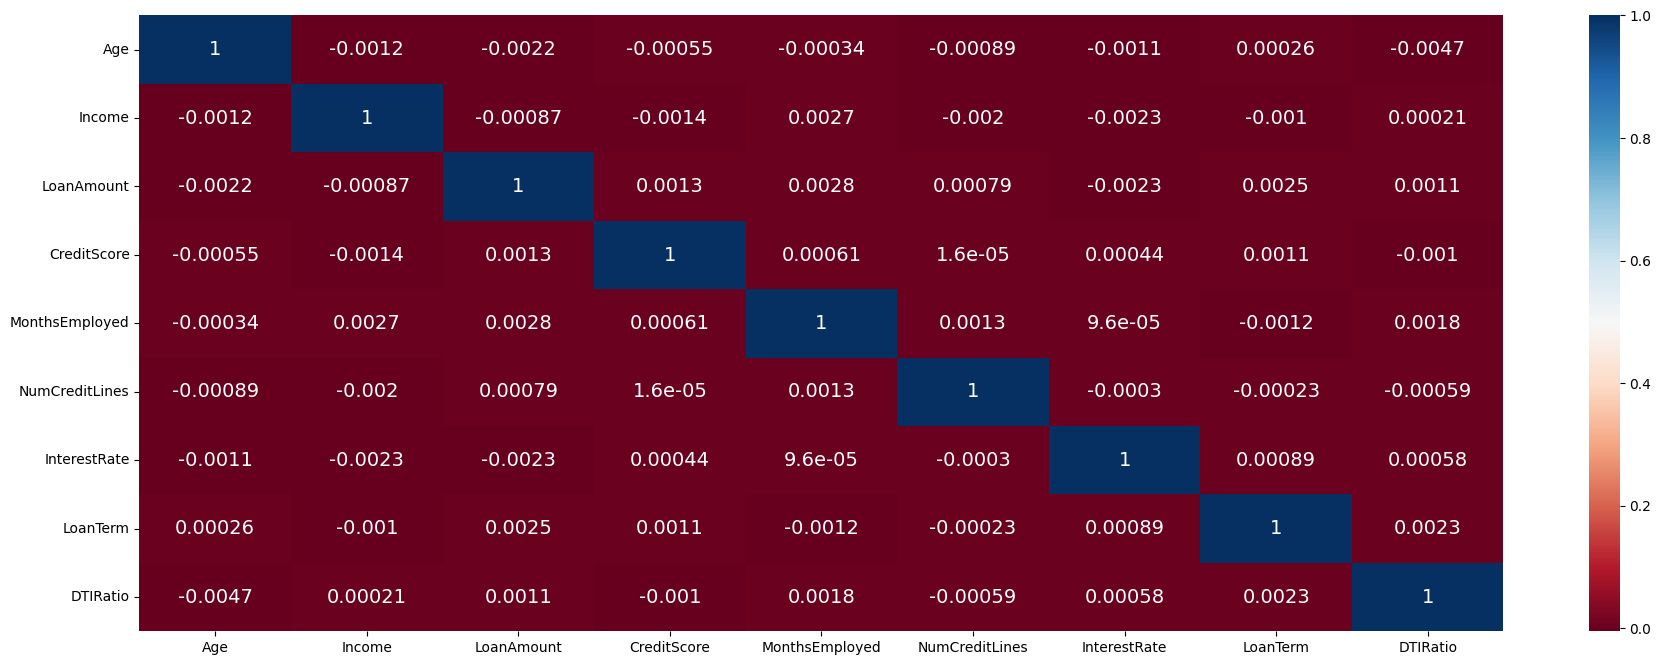

In [38]:
# Checking for correlation and multicollinearity between variables
fig, ax = plt.subplots(figsize=(22, 8))
corr_matrix = df.loc[
    :, ~df.columns.isin(["Default"])
].corr(numeric_only=True)
corr_heatmap = sns.heatmap(
    corr_matrix, annot=True, cmap="RdBu", ax=ax, annot_kws={"size": 14}
)
plt.show()

Note: It seems like none of the numerical features have significant correlation between each other; these features can be used for modelling (strong correlation == multicollinerity)

# 3: Data Preparation

- Drop columns 
  - Drop "LoanID" -> not relevant as var
- Standardize name to be all snake_case instead 
- Encoding categorical features
  - One-hot encodings are used to encode the nominal variables into a series of binary flags, each represents whether the value exists
- Feature scaling
  - rescale the numeric features so that their values can fall in the same range. It is a common requirement by machine learning algorithms for speed and accuracy
- Resampling (Oversampling/Undersampling)
- Train-test split
  - 70/30 split

In [42]:
categorical_vars = ["Education", "EmploymentType", "MaritalStatus", "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]
numerical_vars = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio"]

In [44]:
# Drop LoanID as var
cleaned_df = df.drop(["LoanID"], axis=1)

In [45]:
# Perform one-hot encoding for categorical columns
cleaned_df = pd.get_dummies(cleaned_df, columns=categorical_vars, prefix=categorical_vars)
cleaned_df

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0        56   85994       50587          520              80               4   
1        69   50432      124440          458              15               1   
2        46   84208      129188          451              26               3   
3        32   31713       44799          743               0               3   
4        60   20437        9139          633               8               4   
...     ...     ...         ...          ...             ...             ...   
255342   19   37979      210682          541             109               4   
255343   32   51953      189899          511              14               2   
255344   56   84820      208294          597              70               3   
255345   42   85109       60575          809              40               1   
255346   62   22418       18481          636             113               2   

        InterestRate  LoanTerm  DTIRatio  Default  ...  HasMortgage_Yes  \
0              15.23        36      0.44        0  ...             True   
1               4.81        60      0.68        0  ...            False   
2              21.17        24      0.31        1  ...             True   
3               7.07        24      0.23        0  ...            False   
4               6.51        48      0.73        0  ...            False   
...              ...       ...       ...      ...  ...              ...   
255342         14.11        12      0.85        0  ...            False   
255343         11.55        24      0.21        1  ...            False   
255344          5.29        60      0.50        0  ...             True   
255345         20.90        48      0.44        0  ...             True   
255346          6.73        12      0.48        0  ...             True   

        HasDependents_No  HasDependents_Yes  LoanPurpose_Auto  \
0                  False               True             False   
1                   True              False             False   
2                  False               True              True   
3                   True              False             False   
4                  False               True              True   
...                  ...                ...               ...   
255342              True              False             False   
255343              True              False             False   
255344             False               True              True   
255345             False               True             False   
255346              True              False             False   

        LoanPurpose_Business  LoanPurpose_Education  LoanPurpose_Home  \
0                      False                  False             False   
1                      False                  False             False   
2                      False                  False             False   
3                       True                  False             False   
4                      False                  False             False   
...                      ...                    ...               ...   
255342                 False                  False             False   
255343                 False                  False              True   
255344                 False                  False             False   
255345                 False                  False             False   
255346                 False                   True             False   

        LoanPurpose_Other  HasCoSigner_No  HasCoSigner_Yes  
0                    True           False             True  
1                    True           False             True  
2                   False            True            False  
3                   False            True            False  
4                   False            True            False  
...                   ...             ...              ...  
255342               True            True            False  


In [48]:
# Feature scaling
# NOTE: for numerical dataset so that they have a mean of 0 and a standard deviation of 1. This helps ensure that all features are on a similar scale, making it easier for machine learning algorithms to learn and converge efficiently.

# Select the numeric cols
numeric_cols = cleaned_df.select_dtypes(include=["int64", "float64"]).columns
standardise_cols = [col for col in numeric_cols if col not in ["Default"]]

scaler = StandardScaler()
# Fit and transform the scaler on the selected columns
cleaned_df[standardise_cols] = scaler.fit_transform(cleaned_df[standardise_cols])

In [49]:
cleaned_df

Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
0       0.833990  0.089693   -1.086833    -0.341492        0.590533   
1       1.701221 -0.823021   -0.044309    -0.731666       -1.285731   
2       0.166888  0.043854    0.022715    -0.775718       -0.968209   
3      -0.767053 -1.303452   -1.168538     1.061875       -1.718715   
4       1.100830 -1.592855   -1.671921     0.369631       -1.487790   
...          ...       ...         ...          ...             ...   
255342 -1.634285 -1.142632    1.173101    -0.209337        1.427636   
255343 -0.767053 -0.783984    0.879724    -0.398130       -1.314597   
255344  0.833990  0.059562    1.139391     0.143078        0.301877   
255345 -0.099952  0.066979   -0.945840     1.477221       -0.564091   
255346  1.234250 -1.542012   -1.540048     0.388510        1.543098   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  Default  ...  \
0             1.341937      0.261771 -0.001526 -0.260753        0  ...   
1            -1.343791     -1.308350  1.412793  0.778585        0  ...   
2             0.446694      1.156831 -0.708685 -0.823728        1  ...   
3             0.446694     -0.967805 -0.708685 -1.170174        0  ...   
4             1.341937     -1.052188  0.705634  0.995114        0  ...   
...                ...           ...       ...       ...      ...  ...   
255342        1.341937      0.093006 -1.415845  1.514783        0  ...   
255343       -0.448549     -0.292744 -0.708685 -1.256785        1  ...   
255344        0.446694     -1.236022  1.412793 -0.000918        0  ...   
255345       -1.343791      1.116146  0.705634 -0.260753        0  ...   
255346       -0.448549     -1.019038 -1.415845 -0.087530        0  ...   

        HasMortgage_Yes  HasDependents_No  HasDependents_Yes  \
0                  True             False               True   
1                 False              True              False   
2                  True             False               True   
3                 False              True              False   
4                 False             False               True   
...                 ...               ...                ...   
255342            False              True              False   
255343            False              True              False   
255344             True             False               True   
255345             True             False               True   
255346             True              True              False   

        LoanPurpose_Auto  LoanPurpose_Business  LoanPurpose_Education  \
0                  False                 False                  False   
1                  False                 False                  False   
2                   True                 False                  False   
3                  False                  True                  False   
4                   True                 False                  False   
...                  ...                   ...                    ...   
255342             False                 False                  False   
255343             False                 False                  False   
255344              True                 False                  False   
255345             False                 False                  False   
255346             False                 False                   True   

        LoanPurpose_Home  LoanPurpose_Other  HasCoSigner_No  HasCoSigner_Yes  
0                  False               True           False             True  
1                  False               True           False             True  
2                  False              False            True            False  
3                  False              False            True            False  
4                  False              False            True            False  
...                  ...                ...             ...              ...  
255342             False               True            True            F

In [51]:
# Set Independent and Dependent Variables
X = cleaned_df.drop("Default", axis=1)
y = cleaned_df["Default"]

In [52]:
# Split to training, validation and test dataset ('re using 70/30 - train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=28
)

In [54]:
# Oversampling to achieve balanced class for target variable
smote = SMOTE(sampling_strategy="auto", random_state=28)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

y_resampled.value_counts()

Default
0    158021
1    158021
Name: count, dtype: int64

In [55]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_resampled: {X_resampled.shape}")
print(f"y_resampled: {y_resampled.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (178742, 31)
y_train: (178742,)
X_resampled: (316042, 31)
y_resampled: (316042,)
X_test: (76605, 31)
y_test: (76605,)


In [56]:
X_resampled.dtypes

Age                             float64
Income                          float64
LoanAmount                      float64
CreditScore                     float64
MonthsEmployed                  float64
NumCreditLines                  float64
InterestRate                    float64
LoanTerm                        float64
DTIRatio                        float64
Education_Bachelor's               bool
Education_High School              bool
Education_Master's                 bool
Education_PhD                      bool
EmploymentType_Full-time           bool
EmploymentType_Part-time           bool
EmploymentType_Self-employed       bool
EmploymentType_Unemployed          bool
MaritalStatus_Divorced             bool
MaritalStatus_Married              bool
MaritalStatus_Single               bool
HasMortgage_No                     bool
HasMortgage_Yes                    bool
HasDependents_No                   bool
HasDependents_Yes                  bool
LoanPurpose_Auto                   bool


Note:
- After data preparation there are 178742 rows and 31 columns/variables including the one-hot encoded categorical vars for training. 

# 4: Machine Learning Modelling

In this section, we will test with 3 types of classifiers namely:

1. Base Classifier
 - Logistic Regression
   - models the probability of a binary outcome using a linear combination of input features; its simplicity and interpretability are key advantages.
 - Decision Tree
   - recursively partitions the feature space into regions to make predictions; it can capture complex relationships and interactions in the data.
2. Ensemble
 - Random Forest
   - builds multiple decision trees and aggregates their predictions where it reduces overfitting and is robust to noisy data.
 - LightGBM
   - uses gradient boosting with tree-based model where it is known for its high efficiency and ability to handle large datasets.
3. Artifical Neural Network (ANN)
 - Multilevel Perceptron
   - have multiple layers of interconnected nodes where it can model complex, nonlinear relationships in the data.


The general workflow would be:
- Fit the model with default parameters.
- Use GridSearchCV for hyperparameter tuning.
- Fit the model with best params from hyperparameter tuning and save the metrics for evaluation later.
- Use K-Fold cross validation (k-5) to test for generality.
- Feature Importance / Permutation Importance to understand the feature's contribution in the prediction.

In [57]:
def get_metrics(model: str, y_test, y_pred):
    """
    Calculate accuracy, precision, recall, F1-score, ROC curve, and AUC for a classification model.
    Also, visualised the Confusion Matrix, Classification Report and ROC curve

    Parameters:
    model (str): Name of the model.
    y_test (array-like): True labels.
    y_pred (array-like): Predicted labels or probabilities.

    Returns:
    metrics_df (DataFrame): Metrics summary.
    cm (array-like): Confusion matrix.
    cr (str): Classification report.
    """
    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame(
        {
            "model": [model],
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1-score": [f1],
            "AUC": [roc_auc],
            "false_positive_rate": [fpr],
            "true_positive_rate": [tpr],
        }
    )
    print(metrics_df)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    sns.heatmap(cm / np.sum(cm), annot=True, fmt="0.2%", cmap="Reds")

    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model}")
    plt.legend(loc="lower right")
    plt.show()

    return metrics_df, cm, cr

## 4.1.1 - Base Classifier - Logistic Regression

In [58]:
# Create an instance of the classifier and assign it to a model variable.
model_lr = LogisticRegression(max_iter=2000)
# Train the model using the fit method and training data.
model_lr.fit(X_resampled, y_resampled)
# Make predictions on the test data.
y_pred_lr = model_lr.predict(X_test)

                 model  accuracy  precision    recall  f1-score       AUC  \
0  logistic_regression   0.88006   0.452593  0.136811   0.21011  0.557486   

               false_positive_rate              true_positive_rate  
0  [0.0, 0.02184032036410385, 1.0]  [0.0, 0.1368114643976713, 1.0]  
Confusion Matrix:
[[66195  1478]
 [ 7710  1222]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     67673
           1       0.45      0.14      0.21      8932

    accuracy                           0.88     76605
   macro avg       0.67      0.56      0.57     76605
weighted avg       0.84      0.88      0.85     76605



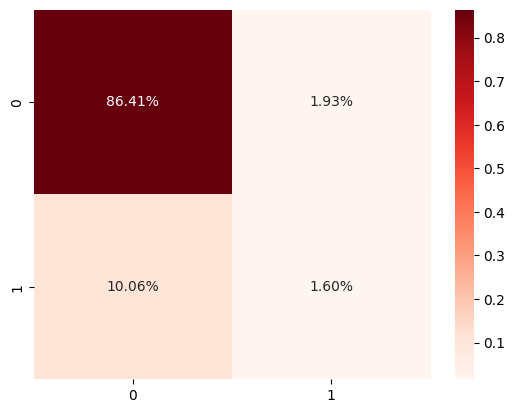

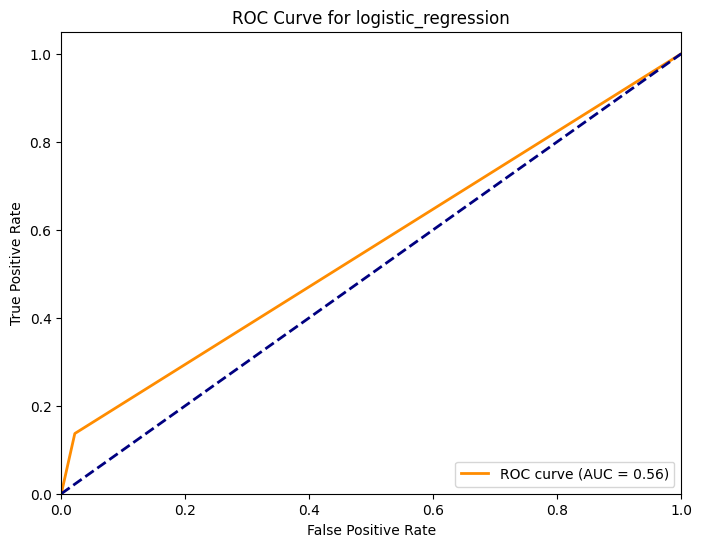

In [59]:
metrics_lr, cm_lr, cr_lr = get_metrics(
    model="logistic_regression", y_test=y_test, y_pred=y_pred_lr
)

In [60]:
# Define hyperparameters and their search space
param_grid = {
    "C": [0.01, 0.1, 1, 10],
}

# Create the grid search model
grid_search_lr = GridSearchCV(model_lr, param_grid, cv=5, scoring="accuracy")

# Fit the grid search to the data
grid_search_lr.fit(X_resampled, y_resampled)

# Get the best hyperparameters and model
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

In [61]:
# Make predictions on the test data using best params from hyperparameter tuning
y_pred_lr = best_model_lr.predict(X_test)

                 model  accuracy  precision    recall  f1-score     AUC  \
0  logistic_regression  0.880086   0.452928  0.136811  0.210146  0.5575   

               false_positive_rate              true_positive_rate  
0  [0.0, 0.02181076647998463, 1.0]  [0.0, 0.1368114643976713, 1.0]  
Confusion Matrix:
[[66197  1476]
 [ 7710  1222]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     67673
           1       0.45      0.14      0.21      8932

    accuracy                           0.88     76605
   macro avg       0.67      0.56      0.57     76605
weighted avg       0.84      0.88      0.85     76605



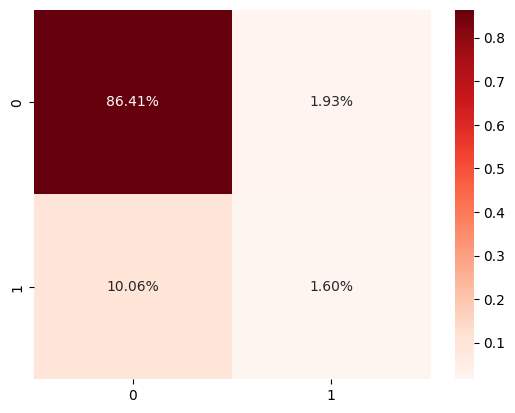

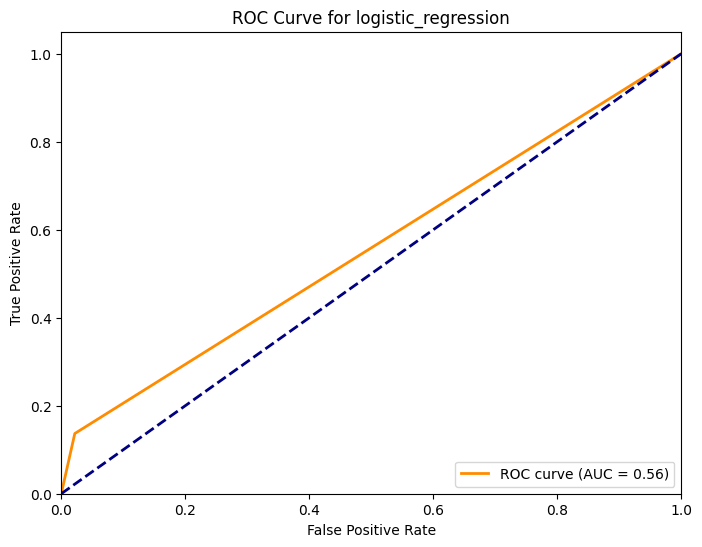

In [62]:
metrics_lr, cm_lr, cr_lr = get_metrics(
    model="logistic_regression", y_test=y_test, y_pred=y_pred_lr
)

Note: Note: It seems like there is no difference between the model and model with best params in terms of metrics.

In [63]:
# Create a KFold cross-validation object with k=5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=28)

# Perform 5-fold cross-validation on the training data using best params from hyperparameter tuning
cross_val_scores_lr = cross_val_score(
    LogisticRegression(max_iter=3000, **best_params_lr),
    X_resampled,
    y_resampled,
    cv=kf,
    scoring="accuracy",
)

In [64]:
# Log the accuracy scores for each fold
for fold, score in enumerate(cross_val_scores_lr, start=1):
    print(f"Fold {fold}: Accuracy = {score}")

# Calculate and print the mean and standard deviation of the scores
mean_score_lr = cross_val_scores_lr.mean()
print(f"Mean Accuracy: {mean_score_lr:.2f}")
print(f"Accuracy from test data: {accuracy_score(y_test, y_pred_lr):.2f}")

Fold 1: Accuracy = 0.8966286446550333
Fold 2: Accuracy = 0.895489566359221
Fold 3: Accuracy = 0.8964529806353626
Fold 4: Accuracy = 0.8983831160612581
Fold 5: Accuracy = 0.9004714593089482
Mean Accuracy: 0.90
Accuracy from test data: 0.88


NOTE: This may indicate that the model is reasonable stable and is able to generalize ll as the mean accuracy from CV is consistent with the accuracy on test data (new, unseen data).

In [65]:
# Get feature coefficients
coefficients_lr = model_lr.coef_
# Create df including their variable name
feature_coef_lr = pd.DataFrame(
    {
        "variables": list(X_resampled.columns),
        "feature_coefficients": coefficients_lr.flatten(),
    }
).sort_values("feature_coefficients", ascending=False)

# Get top 10 features list (5 top positive, and 5 top negative)
# NOTE: positive coefficients are impactful in predicting positive class (1) while negative coefficients for negative class (0)
top_5_feat_lr = list(feature_coef_lr["variables"][:5])
top_5_feat_lr

['EmploymentType_Unemployed',
 'LoanPurpose_Business',
 'Education_High School',
 'LoanPurpose_Other',
 'LoanPurpose_Auto']

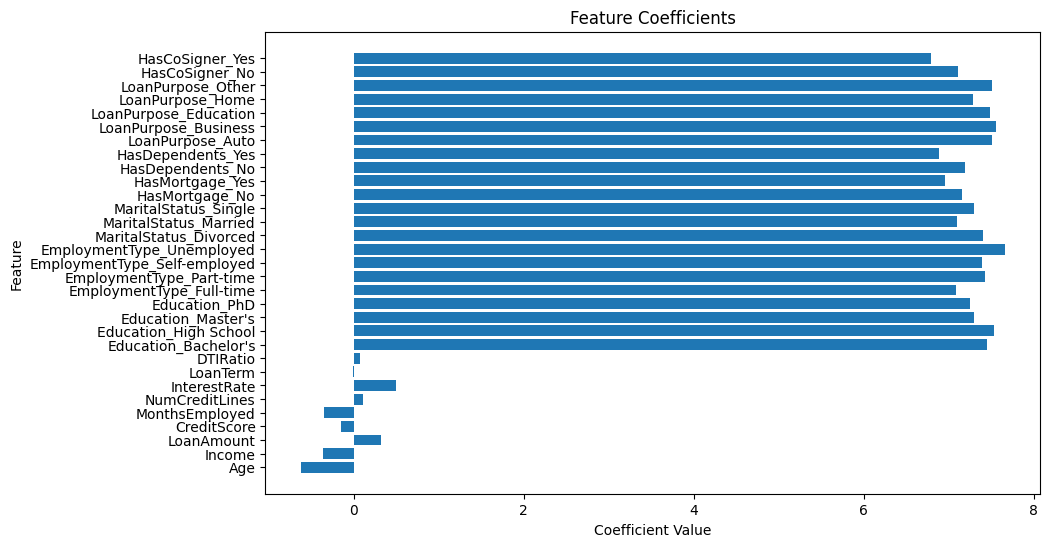

In [66]:
# Create a bar chart of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(list(X_resampled.columns), coefficients_lr[0])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Coefficients")
plt.show()

Note: Most of the financial/numerical features are exhibiting lower coefficient values, while the categorical (encoded) features have stronger coefficient values are in positive direction suggesting that it is significant in predicting 1's

### 4.1.2 Base Classifier - Decision Tree

In [67]:
# Create a Decision Tree classifier
model_dt = DecisionTreeClassifier(random_state=28)

# Train the classifier on the training data
model_dt.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred_dt = model_dt.predict(X_test)

           model  accuracy  precision    recall  f1-score       AUC  \
0  decision_tree  0.769362   0.185981  0.289633  0.226513  0.561157   

              false_positive_rate               true_positive_rate  
0  [0.0, 0.1673193149409661, 1.0]  [0.0, 0.28963278101209133, 1.0]  
Confusion Matrix:
[[56350 11323]
 [ 6345  2587]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     67673
           1       0.19      0.29      0.23      8932

    accuracy                           0.77     76605
   macro avg       0.54      0.56      0.55     76605
weighted avg       0.82      0.77      0.79     76605



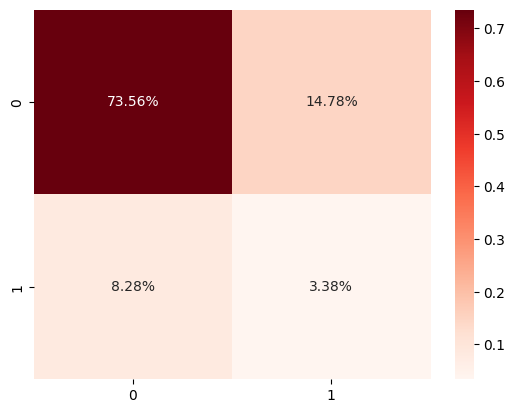

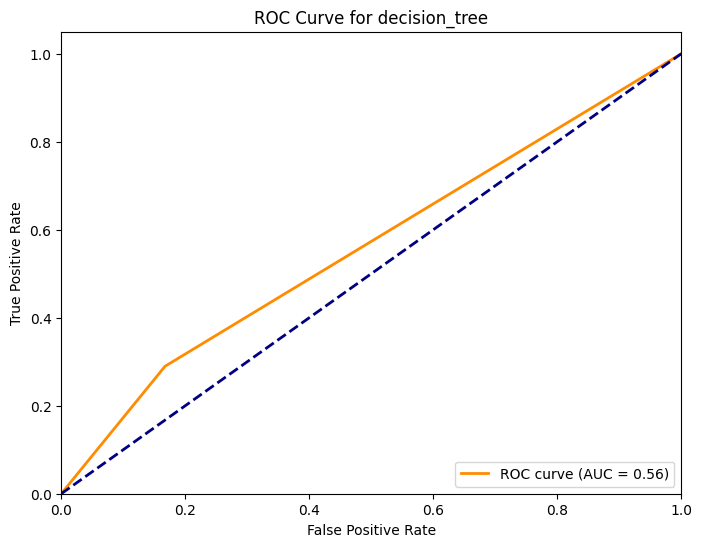

In [68]:
metrics_dt, cm_dt, cr_dt = get_metrics(
    model="decision_tree", y_test=y_test, y_pred=y_pred_dt
)

           model  accuracy  precision    recall  f1-score       AUC  \
0  decision_tree  0.769362   0.185981  0.289633  0.226513  0.561157   

              false_positive_rate               true_positive_rate  
0  [0.0, 0.1673193149409661, 1.0]  [0.0, 0.28963278101209133, 1.0]  
Confusion Matrix:
[[56350 11323]
 [ 6345  2587]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     67673
           1       0.19      0.29      0.23      8932

    accuracy                           0.77     76605
   macro avg       0.54      0.56      0.55     76605
weighted avg       0.82      0.77      0.79     76605



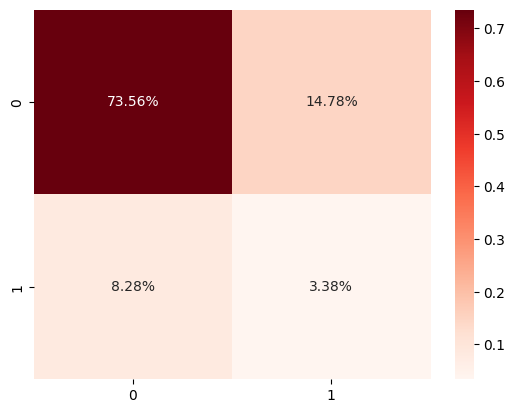

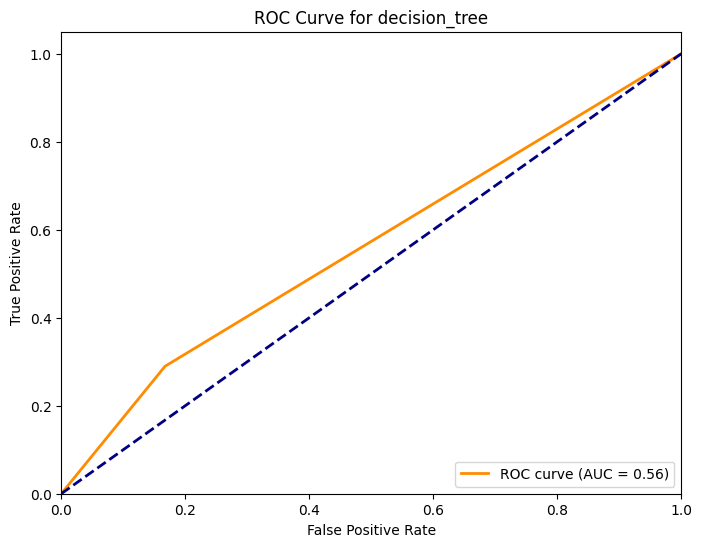

Fold 1: Accuracy = 0.8430286826243099
Fold 2: Accuracy = 0.8379977534844721
Fold 3: Accuracy = 0.8424408302746488
Fold 4: Accuracy = 0.8403841285913175
Fold 5: Accuracy = 0.8422509808884951
Mean Accuracy: 0.84
Accuracy from test data: 0.77


In [69]:
# Define hyperparameters and their search space
param_grid = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Create the grid search model
grid_search_dt = GridSearchCV(model_dt, param_grid, cv=5, scoring="accuracy")

# Fit the grid search to the data
grid_search_dt.fit(X_resampled, y_resampled)

# Get the best hyperparameters and model
best_params_dt = grid_search_dt.best_params_
best_model_dt = grid_search_dt.best_estimator_

# Make predictions on the test data using best params from hyperparameter tuning
y_pred_dt = best_model_dt.predict(X_test)

metrics_dt, cm_dt, cr_dt = get_metrics(
    model="decision_tree", y_test=y_test, y_pred=y_pred_dt
)

# Create a KFold cross-validation object with k=5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=28)

# Perform 5-fold cross-validation on the training data using best params from hyperparameter tuning
cross_val_scores_dt = cross_val_score(
    DecisionTreeClassifier(random_state=28, **best_params_dt),
    X_resampled,
    y_resampled,
    cv=kf,
    scoring="accuracy",
)

# Log the accuracy scores for each fold
for fold, score in enumerate(cross_val_scores_dt, start=1):
    print(f"Fold {fold}: Accuracy = {score}")

# Calculate and print the mean and standard deviation of the scores
mean_score_dt = cross_val_scores_dt.mean()
print(f"Mean Accuracy: {mean_score_dt:.2f}")
print(f"Accuracy from test data: {accuracy_score(y_test, y_pred_dt):.2f}")

NOTE: This may indicate that the model is reasonable stable. However it may suggest overfitting as the accuracy on test data (new, unseen data) is lower than the mean accuracy from cross-validation

In [70]:
# Get feature importances from the trained model
feature_importances_dt = model_dt.feature_importances_
# Create df including their variable name
fi_df = pd.DataFrame(
    {
        "feature": list(X_resampled.columns),
        "importance": feature_importances_dt.flatten(),
    }
).sort_values("importance", ascending=False)

top_5_feat_dt = list(fi_df["feature"][:5])
top_5_feat_dt

['Age', 'InterestRate', 'LoanAmount', 'MonthsEmployed', 'Income']

Text(0.5, 1.0, 'Decision Tree Feature Importance')

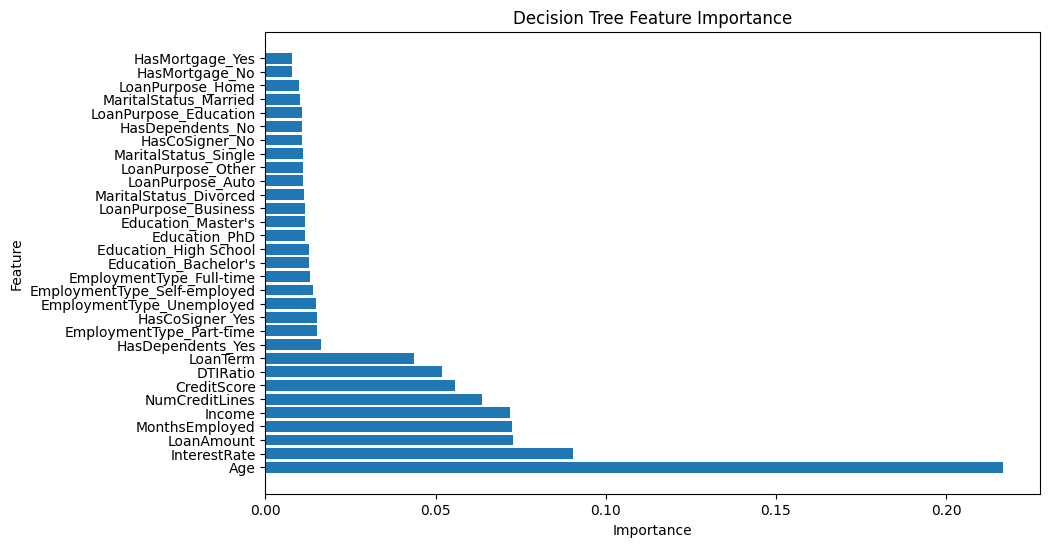

In [71]:
# Create a horizontal bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Decision Tree Feature Importance")

Note: It seems like "age" is the most important feature, and particularly the numerical variables. 

Summary:
Feature Importances
Logistic Regression
- Logistic regression is a linear model, and it assumes a linear relationship between the features and the log-odds of the target variable. When you one-hot encode categorical variables, you create binary (0 or 1) variables for each category, and these binary variables are treated as numerical in logistic regression.
- In logistic regression, the importance of a feature is determined by the magnitude of its coefficient (weight) in the linear equation. Higher magnitude coefficients indicate greater importance.
- One-hot encoding can lead to multicollinearity, where the binary variables derived from the same categorical variable are highly correlated. This can make it challenging for logistic regression to assign meaningful and interpretable coefficients to individual categories, and it might result in some categories having higher coefficients due to the encoding scheme, rather than inherent importance.


Decision Tree
1. Numerical variables seems to have higher feature importance
  - When deciding how to split a node in a decision tree, the algorithm typically uses criteria like Gini impurity or entropy (information gain) to evaluate the quality of a split.
  - For numerical features, the algorithm can test various threshold values to find the one that minimizes impurity, potentially leading to more informative splits.
  - Categorical features, on the other hand, are often one-hot encoded, creating binary splits for each category. These binary splits may not always result in substantial impurity reduction because the individual categories might not be strongly associated with the target variable. This can lead to lower importance scores for categorical features, especially if the categories are not highly predictive.
  - Therefore, it may indicate that the encoding or the structure of the data doesn't allow the decision tree to effectively capture the relationships within categorical features.

## 4.2 Ensemble

### 4.2.1 Ensemble - Random Forest

In [72]:
# Create a Random Forest classifier with default hyperparameters
model_rf = RandomForestClassifier(random_state=28)

# Train the Random Forest classifier on the training data
model_rf.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred_rf = model_rf.predict(X_test)

           model  accuracy  precision  recall  f1-score      AUC  \
0  random_forest   0.87245   0.385037  0.1573  0.223353  0.56207   

                false_positive_rate               true_positive_rate  
0  [0.0, 0.033159457981765256, 1.0]  [0.0, 0.15729959695476936, 1.0]  
Confusion Matrix:
[[65429  2244]
 [ 7527  1405]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     67673
           1       0.39      0.16      0.22      8932

    accuracy                           0.87     76605
   macro avg       0.64      0.56      0.58     76605
weighted avg       0.84      0.87      0.85     76605



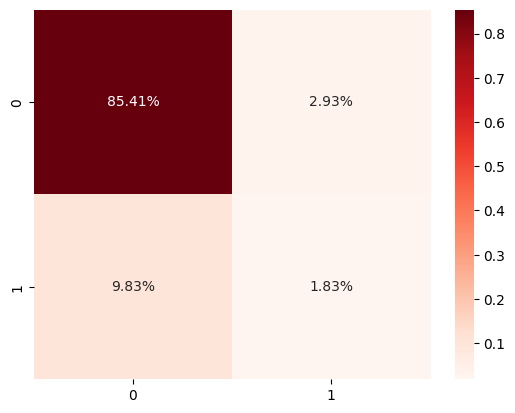

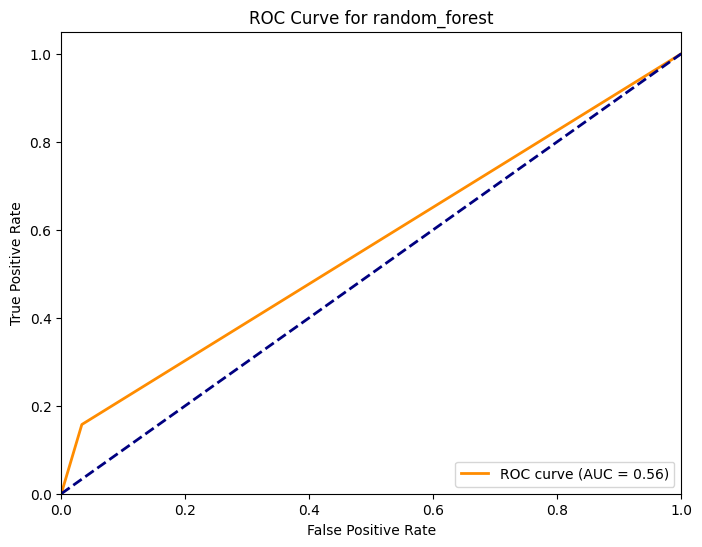

In [73]:
metrics_rf, cm_rf, cr_rf = get_metrics(
    model="random_forest", y_test=y_test, y_pred=y_pred_rf
)

  model  accuracy  precision    recall  f1-score       AUC  \
0    rf  0.873651   0.392146  0.152038  0.219121  0.560466   

               false_positive_rate               true_positive_rate  
0  [0.0, 0.03110546303547944, 1.0]  [0.0, 0.15203761755485892, 1.0]  
Confusion Matrix:
[[65568  2105]
 [ 7574  1358]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     67673
           1       0.39      0.15      0.22      8932

    accuracy                           0.87     76605
   macro avg       0.64      0.56      0.58     76605
weighted avg       0.84      0.87      0.85     76605



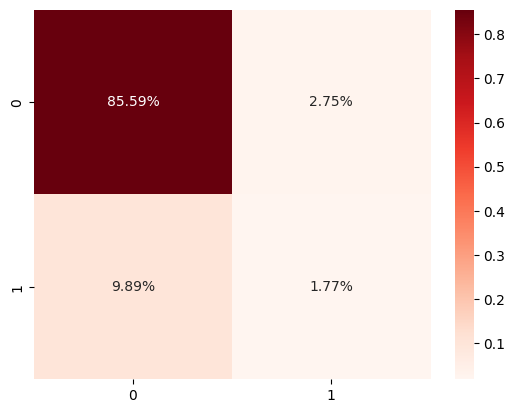

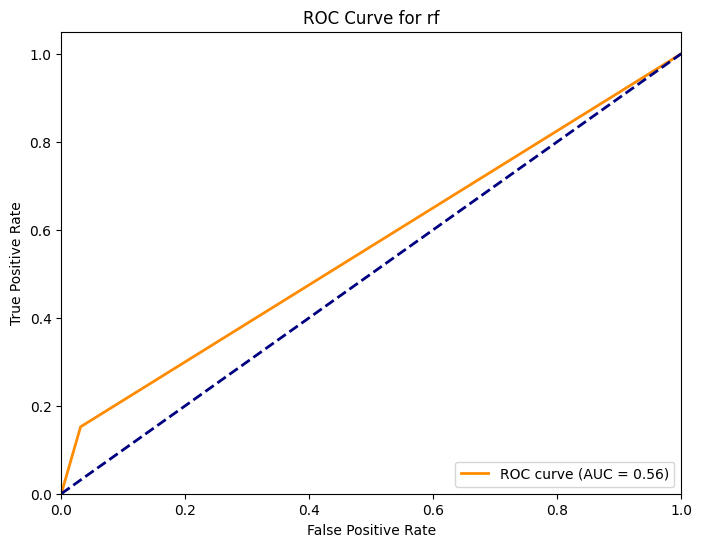

Fold 1: Accuracy = 0.9510038127481846
Fold 2: Accuracy = 0.9507032226423452
Fold 3: Accuracy = 0.9513352740159473
Fold 4: Accuracy = 0.9500379698772308
Fold 5: Accuracy = 0.9506549803822301
Mean Accuracy: 0.95
Accuracy from test data: 0.87


In [74]:
# Define hyperparameters and their search space
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# Create the grid search model
grid_search_rf = GridSearchCV(model_rf, param_grid, cv=5, scoring="accuracy")

# Fit the grid search to the data
# NOTE: Grid search runtime around 200 mins+
grid_search_rf.fit(X_resampled, y_resampled)

# # Get the best hyperparameters and model
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

# Make predictions on the test data using best params from hyperparameter tuning
y_pred_rf = best_model_rf.predict(X_test)

metrics_rf, cm_rf, cr_rf = get_metrics(model="rf", y_test=y_test, y_pred=y_pred_rf)

# Create a KFold cross-validation object with k=5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=28)

# Perform 5-fold cross-validation on the training data using best params from hyperparameter tuning
cross_val_scores_rf = cross_val_score(
    RandomForestClassifier(**best_params_rf, random_state=28),
    X_resampled,
    y_resampled,
    cv=kf,
    scoring="accuracy",
)

# Log the accuracy scores for each fold
for fold, score in enumerate(cross_val_scores_rf, start=1):
    print(f"Fold {fold}: Accuracy = {score}")

# Calculate and print the mean and standard deviation of the scores
mean_score_rf = cross_val_scores_rf.mean()
print(f"Mean Accuracy: {mean_score_rf:.2f}")
print(f"Accuracy from test data: {accuracy_score(y_test, y_pred_rf):.2f}")

NOTE: This may indicate that the model is reasonable stable as the accuracy from each fold seems consistent. Hover it may suggest overfitting as the accuracy on test data (new, unseen data) is lower than the mean accuracy from cross-validation

In [75]:
# Get feature importances from the trained Random Forest classifier
feature_importances_rf = model_rf.feature_importances_
fi_df_rf = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances_rf}
).sort_values("importance", ascending=False)

top_5_feat_rf = list(fi_df_rf["feature"][:5])
top_5_feat_rf

['Age', 'InterestRate', 'Income', 'MonthsEmployed', 'LoanAmount']

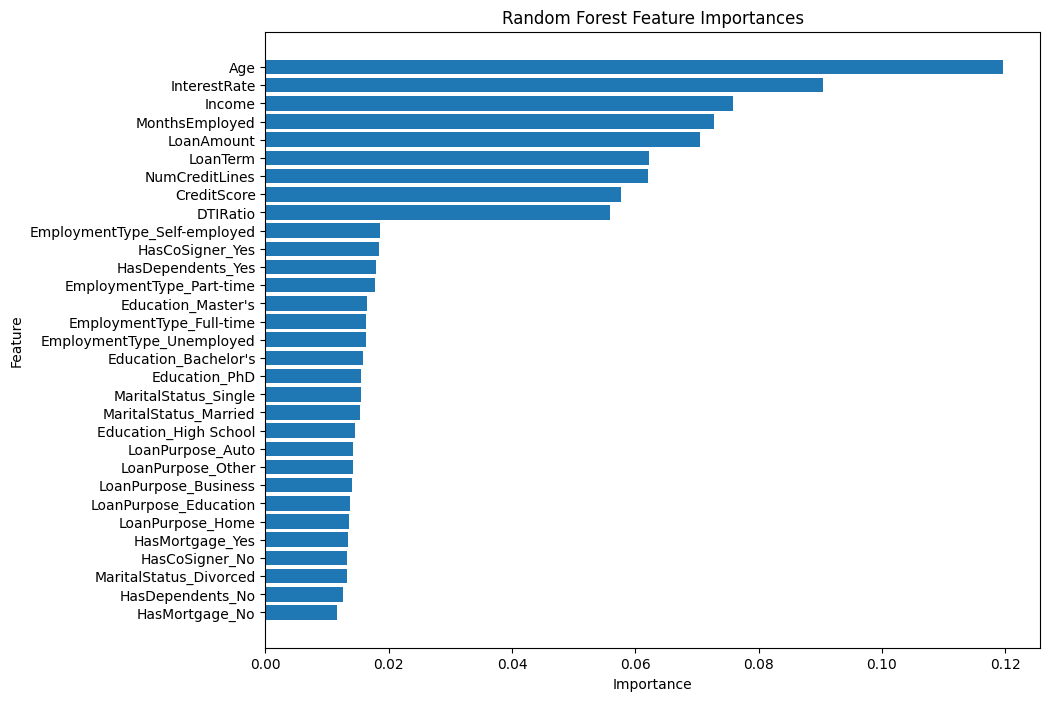

In [76]:
plt.figure(figsize=(10, 8))
plt.barh(fi_df_rf["feature"], fi_df_rf["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()

### 4.2.2 Ensemble - LightGBM

In [77]:
# Create and train a LightGBM classifier
model_lgb = lgb.LGBMClassifier(random_state=28)
model_lgb.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_lgb = model_lgb.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158021, number of negative: 158021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 316042, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


      model  accuracy  precision    recall  f1-score       AUC  \
0  lightgbm  0.884838   0.554134  0.063032  0.113189  0.528169   

                false_positive_rate               true_positive_rate  
0  [0.0, 0.006693954753003413, 1.0]  [0.0, 0.06303179579041648, 1.0]  
Confusion Matrix:
[[67220   453]
 [ 8369   563]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     67673
           1       0.55      0.06      0.11      8932

    accuracy                           0.88     76605
   macro avg       0.72      0.53      0.53     76605
weighted avg       0.85      0.88      0.84     76605



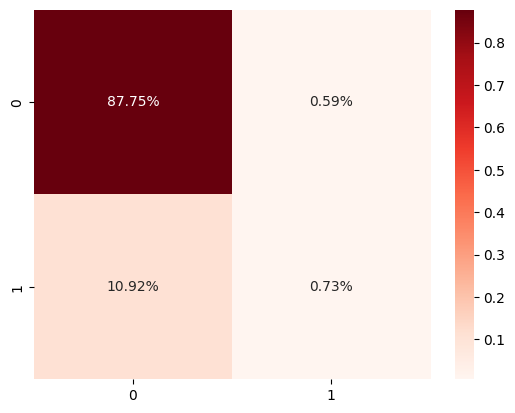

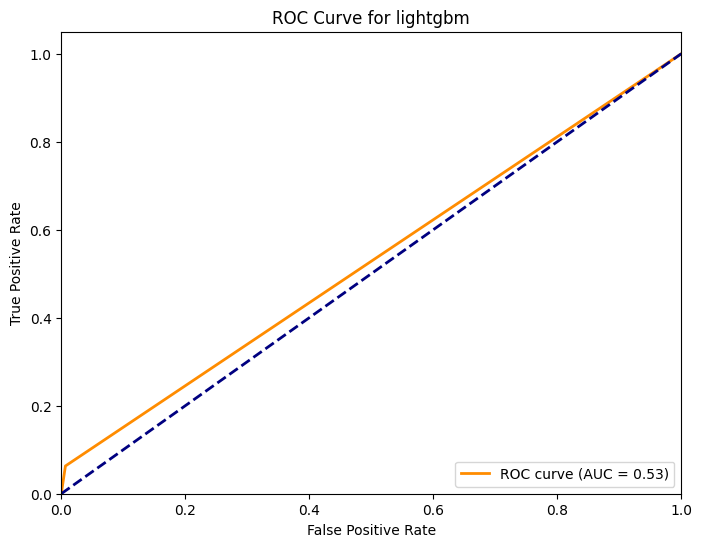

In [78]:
metrics_lgb, cm_lgb, cr_lgb = get_metrics(
    model="lightgbm", y_test=y_test, y_pred=y_pred_lgb
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126417, number of negative: 126416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 252833, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000008
[LightGBM] [Info] Start training from score 0.000008
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126416, number of negative: 126417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `forc

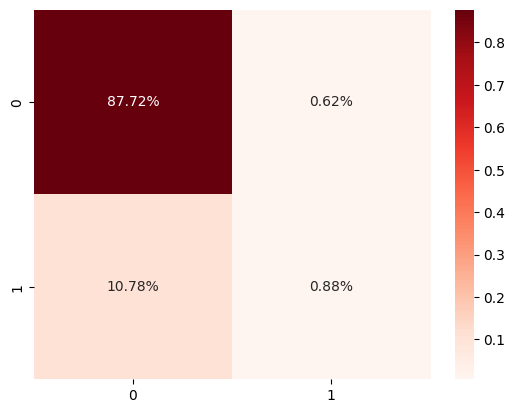

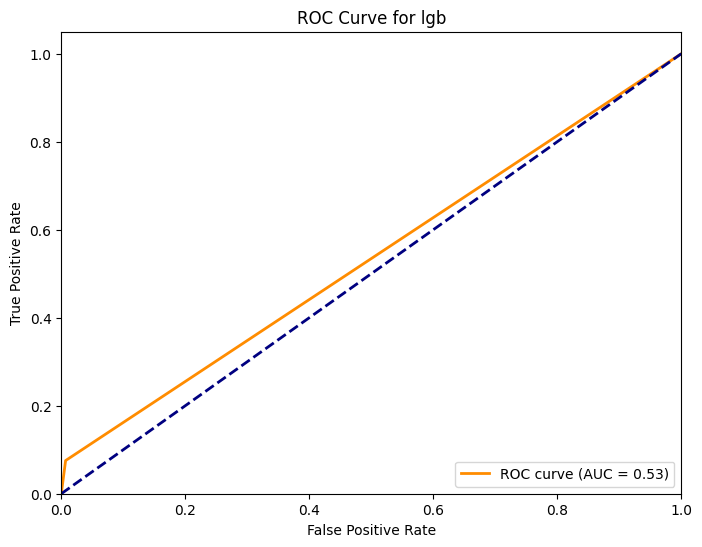

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126189, number of negative: 126644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 252833, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499100 -> initscore=-0.003599
[LightGBM] [Info] Start training from score -0.003599
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126252, number of negative: 126581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [79]:
# Define hyperparameters and their search space
param_grid = {
    "num_leaves": [20, 30, 40],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
}

# Create the grid search model
grid_search_lgb = GridSearchCV(
    lgb.LGBMClassifier(), param_grid, cv=5, scoring="accuracy"
)

# Fit the grid search to the data
grid_search_lgb.fit(X_resampled, y_resampled)

# Get the best hyperparameters and model
best_params_lgb = grid_search_lgb.best_params_
best_model_lgb = grid_search_lgb.best_estimator_

# Make predictions on the test data using best params from hyperparameter tuning
y_pred_lgb = best_model_lgb.predict(X_test)

metrics_lgb, cm_lgb, cr_lgb = get_metrics(model="lgb", y_test=y_test, y_pred=y_pred_lgb)

# Create a KFold cross-validation object with k=5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=28)

# Perform 5-fold cross-validation on the training data using best params from hyperparameter tuning
cross_val_scores_lgb = cross_val_score(
    lgb.LGBMClassifier(**best_params_lgb, random_state=28),
    X_resampled,
    y_resampled,
    cv=kf,
    scoring="accuracy",
)

In [80]:
# Log the accuracy scores for each fold
for fold, score in enumerate(cross_val_scores_lgb, start=1):
    print(f"Fold {fold}: Accuracy = {score}")

# Calculate and print the mean and standard deviation of the scores
mean_score_lgb = cross_val_scores_lgb.mean()
print(f"Mean Accuracy: {mean_score_lgb:.2f}")
print(f"Accuracy from test data: {accuracy_score(y_test, y_pred_lgb):.2f}")

Fold 1: Accuracy = 0.931781866506352
Fold 2: Accuracy = 0.9315920201237166
Fold 3: Accuracy = 0.9306258701430199
Fold 4: Accuracy = 0.9329040627768637
Fold 5: Accuracy = 0.9346127072522465
Mean Accuracy: 0.93
Accuracy from test data: 0.89


NOTE: This may indicate that the model is reasonable stable as the accuracy from each fold seems consistent. Hover it may suggest overfitting as the accuracy on test data (new, unseen data) is lower than the mean accuracy from cross-validation

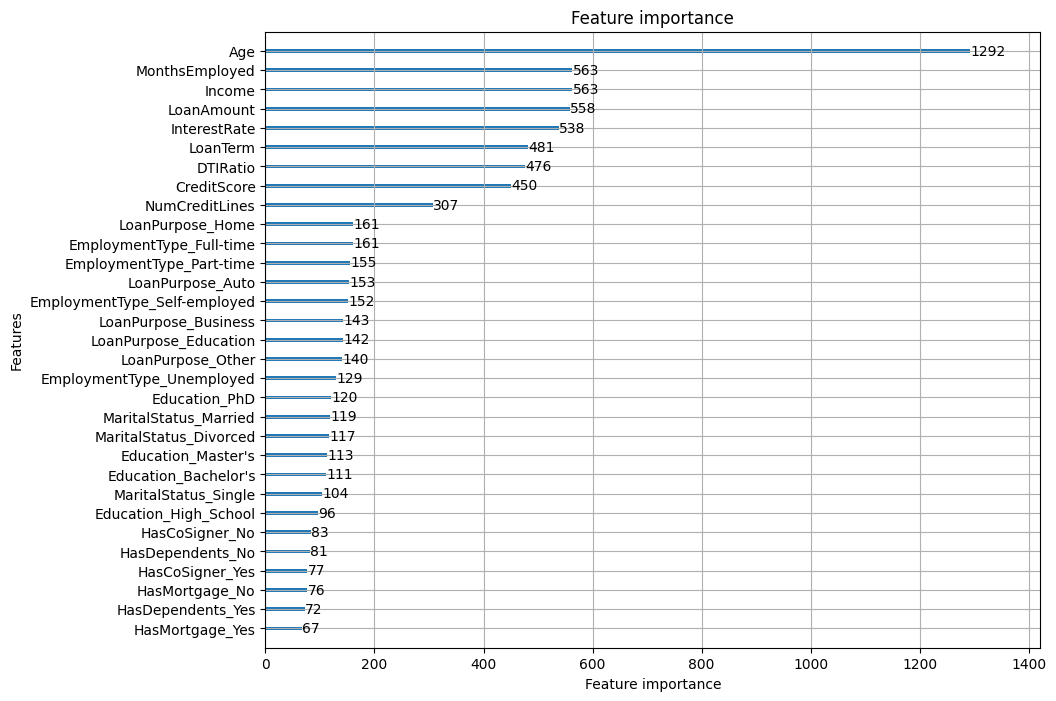

In [81]:
# Plot feature importance (split-based)
lgb.plot_importance(best_model_lgb, importance_type="split", figsize=(10, 8))
plt.show()

In [82]:
# Get feature importance (split-based) as a list
feature_importance_lgb_split = best_model_lgb.booster_.feature_importance(
    importance_type="split"
)

fi_df_lgb = pd.DataFrame(
    {
        "feature": X_resampled.columns,
        "feature_importance": feature_importance_lgb_split,
        "type": "split",
    }
).sort_values("feature_importance", ascending=False)

top_5_feat_lgb = list(fi_df_lgb["feature"][:5])
top_5_feat_lgb

['Age', 'MonthsEmployed', 'Income', 'LoanAmount', 'InterestRate']

Note: The importance score based on the number of times a feature is used to split the data across all trees in the ensemble. It still seems consistent with other models where interest rate has the highest importance.

## 4.4 Neural Network - Artificial Neural Network (ANN)

### 4.4.1 Multilevel Perceptron

In [91]:
X_resampled.apply(lambda x: x.astype("float32"))

Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
0       0.567149  0.328561    0.104575    -0.725373        1.543098   
1       1.300960 -1.602736    0.200085     1.640842       -0.766150   
2      -0.366793  0.443593   -0.460102     0.860495        1.283308   
3      -1.434155 -0.233306   -1.460997    -1.360979        0.936920   
4       1.167540 -0.823739   -1.651340    -1.077788        1.225577   
...          ...       ...         ...          ...             ...   
316037 -0.519133 -0.005620   -1.334919    -0.361502       -0.318521   
316038  1.447398  1.300081    0.339753    -0.061986       -0.557756   
316039 -1.565783 -0.222777    1.111876     1.169268       -1.486240   
316040  0.293643 -0.176953   -0.513657    -0.691960       -1.565758   
316041  1.108202 -1.492057    1.650841     1.189059        1.573559   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  \
0            -1.343791      0.520947  1.412793 -0.996951   
1            -0.448549     -0.238498 -1.415845 -0.347364   
2             0.446694     -0.309319 -0.708685  1.211643   
3             1.341937      0.447112  1.412793  0.778585   
4            -1.343791     -0.880409 -0.708685  0.432139   
...                ...           ...       ...       ...   
316037       -0.448549      1.349435  0.452334  1.071399   
316038       -1.343791      1.399180 -0.708685 -0.349177   
316039       -1.343791     -0.520430 -0.727676 -1.203013   
316040       -1.254339      1.459732  0.776293 -1.611955   
316041       -0.399084      0.083429  0.705634  1.719348   

        Education_Bachelor's  ...  HasMortgage_Yes  HasDependents_No  \
0                        0.0  ...              0.0               1.0   
1                        1.0  ...              1.0               0.0   
2                        0.0  ...              0.0               1.0   
3                        1.0  ...              1.0               1.0   
4                        0.0  ...              0.0               1.0   
...                      ...  ...              ...               ...   
316037                   1.0  ...              1.0               1.0   
316038                   0.0  ...              0.0               1.0   
316039                   1.0  ...              0.0               1.0   
316040                   1.0  ...              1.0               0.0   
316041                   1.0  ...              0.0               1.0   

        HasDependents_Yes  LoanPurpose_Auto  LoanPurpose_Business  \
0                     0.0               1.0                   0.0   
1                     1.0               1.0                   0.0   
2                     0.0               0.0                   1.0   
3                     0.0               0.0                   1.0   
4                     0.0               0.0                   1.0   
...                   ...               ...                   ...   
316037                0.0               0.0                   0.0   
316038                0.0               0.0                   1.0   
316039                0.0               0.0                   0.0   
316040                1.0               1.0                   0.0   
316041                0.0               0.0                   0.0   

        LoanPurpose_Education  LoanPurpose_Home  LoanPurpose_Other  \
0                         0.0               0.0                0.0   
1                         0.0               0.0                0.0   
2                         0.0               0.0                0.0   
3                         0.0               0.0                0.0   
4                         0.0               0.0                0.0   
...                       ...               ...                ...   
316037                    0.0               0.0                1.0   
316038                    1.0               0.0                0.0   
316039                    0.0               0.0                1.0   
316040                    0.0               0

In [94]:

# Define the input shape based on the number of features in your dataset
# Change bools to float32 as Tensor doesnt supoort bool
input_shape = X_resampled.shape[1]

# Number of classes (binary classification: 0 for not defaulted, 1 for defaulted)
num_classes = 2

# Define your MLP model using Keras
model_mlp = keras.Sequential([
    layers.Input(shape=(input_shape,)),  # Define the input shape
    layers.Dense(128, activation="relu"),  # Add a hidden layer with 128 units and ReLU activation
    layers.Dense(64, activation="relu"),   # Add another hidden layer with 64 units and ReLU activation
    layers.Dense(num_classes, activation="softmax")  # Output layer with the number of classes and softmax activation
])

# Compile the model
model_mlp.compile(optimizer="adam",  # You can use other optimizers as well
              loss="sparse_categorical_crossentropy",  # For classification tasks
              metrics=["accuracy"])

# Train the model on your training data
model_mlp.fit(X_resampled.apply(lambda x: x.astype("float32")), y_resampled, epochs=10, batch_size=32)  # You can adjust the number of epochs and batch size

# Make predictions on the test data
y_pred_keras = model_mlp.predict(X_test.apply(lambda x: x.astype("float32")))

# Convert probabilities to class labels
y_pred_keras_labels = np.argmax(y_pred_keras, axis=-1)

Epoch 1/10


9877/9877 [==============================] - 15s 2ms/step - loss: 0.2744 - accuracy: 0.8822
Epoch 2/10
9877/9877 [==============================] - 15s 1ms/step - loss: 0.2387 - accuracy: 0.8988
Epoch 3/10
9877/9877 [==============================] - 14s 1ms/step - loss: 0.2357 - accuracy: 0.8999
Epoch 4/10
9877/9877 [==============================] - 15s 1ms/step - loss: 0.2332 - accuracy: 0.9011
Epoch 5/10
9877/9877 [==============================] - 14s 1ms/step - loss: 0.2309 - accuracy: 0.9023
Epoch 6/10
9877/9877 [==============================] - 15s 1ms/step - loss: 0.2284 - accuracy: 0.9040
Epoch 7/10
9877/9877 [==============================] - 14s 1ms/step - loss: 0.2255 - accuracy: 0.9055
Epoch 8/10
9877/9877 [==============================] - 15s 1ms/step - loss: 0.2230 - accuracy: 0.9072
Epoch 9/10
9877/9877 [==============================] - 14s 1ms/step - loss: 0.2206 - accuracy: 0.9086
Epoch 10/10
2394/2394 [==============================] - 2s 1ms/step


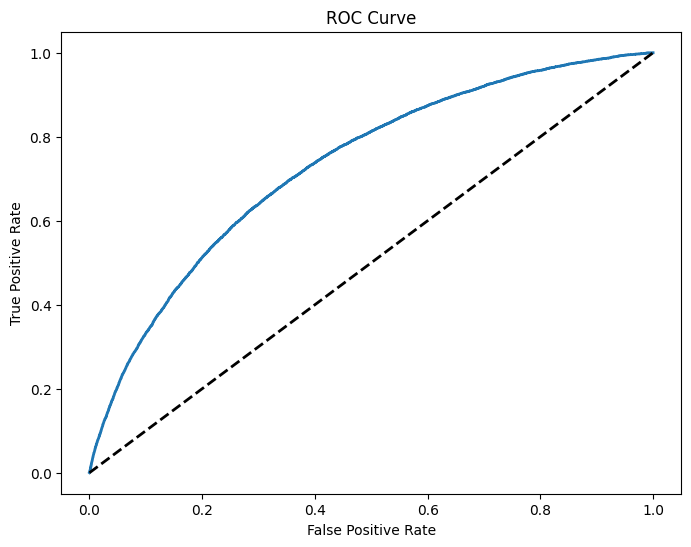

Accuracy: 0.8715358005352131
Recall: 0.14453649798477386
F1 Score: 0.20784029622474443
AUC-ROC Score: 0.7316406098598176


In [113]:
# Convert it to a 1D array with binary labels (0 or 1)
y_test_binary = y_test.array # Assuming that the second column (index 1) contains the positive class

# Calculate metrics using y_test_binary
accuracy = accuracy_score(y_test_binary, y_pred_keras_labels)
precision = precision_score(y_test_binary, y_pred_keras_labels)
recall = recall_score(y_test_binary, y_pred_keras_labels)
f1 = f1_score(y_test_binary, y_pred_keras_labels)

# Calculate AUC-ROC score and plot ROC curve using y_pred_keras[:, 1]
roc_auc = roc_auc_score(y_test_binary, y_pred_keras[:, 1])
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_keras[:, 1])

metrics_mlp = pd.DataFrame(
        {
            "model": "MLP",
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1-score": [f1],
            "AUC": [roc_auc],
            "false_positive_rate": [fpr],
            "true_positive_rate": [tpr],
        }
    )

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='45-degree line')  # Adding the 45-degree line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the calculated metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)


In [127]:
# Define a function to create your Keras model
def create_mlp_model(
    input_shape, num_classes, optimizer="adam", hidden_units=128, activation="relu"
):
    model = keras.Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Create a KerasClassifier based on your model function
keras_model = KerasClassifier(
    model=create_mlp_model, input_shape=input_shape, num_classes=num_classes, verbose=0
)

# Define hyperparameters and values to search
param_grid = {
    "batch_size": [32, 64, 128],
    "epochs": [10, 20, 30],
}

# Perform grid search or randomized search
grid_search = GridSearchCV(
    estimator=keras_model, param_grid=param_grid, scoring="f1", cv=3
)
# Or use RandomizedSearchCV for a random search
# random_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_grid, scoring='accuracy', cv=3)

# Fit the search to your data
grid_search_result = grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search_result.best_params_)

Best Hyperparameters:  {'batch_size': 128, 'epochs': 30}


In [284]:
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	# Input_dim = 31 features
	model.add(Dense(12, input_dim=31, activation="relu"))
	model.add(Dense(8, activation="relu"))
	model.add(Dense(1, activation="sigmoid"))
	# Compile model
	model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
	return model

model_mlp = create_model()

# Create model using best hyperparameters
best_model_mlp = KerasClassifier(model=model_mlp, epochs=30, batch_size=128, verbose=0)

In [285]:
# Evaluate using 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=28)
results = cross_val_score(
    best_model_mlp,
    X_resampled.apply(lambda x: x.astype("float32")),
    y_resampled,
    cv=kfold,
)

INFO:tensorflow:Assets written to: ram://ec2f532a6d464596b2148be77de25e84/assets


INFO:tensorflow:Assets written to: ram://ec2f532a6d464596b2148be77de25e84/assets
2023-10-05 14:05:19.792646: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://8bd9f0a2fa474b158c7688792d3632c6: INVALID_ARGUMENT: ram://8bd9f0a2fa474b158c7688792d3632c6 is a directory.


INFO:tensorflow:Assets written to: ram://03a8b023410f422381d8b04875f52fe5/assets


INFO:tensorflow:Assets written to: ram://03a8b023410f422381d8b04875f52fe5/assets
2023-10-05 14:07:20.800047: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://ce38133789ae4ef491739bbbcc9bcbc8: INVALID_ARGUMENT: ram://ce38133789ae4ef491739bbbcc9bcbc8 is a directory.


INFO:tensorflow:Assets written to: ram://37abb5c5880a4008b7f6e73f837f12a7/assets


INFO:tensorflow:Assets written to: ram://37abb5c5880a4008b7f6e73f837f12a7/assets
2023-10-05 14:09:13.543462: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://312881ebbd98451280b6802af2f22baf: INVALID_ARGUMENT: ram://312881ebbd98451280b6802af2f22baf is a directory.


INFO:tensorflow:Assets written to: ram://5836b80d596a4ed1a37c6af17d5784b2/assets


INFO:tensorflow:Assets written to: ram://5836b80d596a4ed1a37c6af17d5784b2/assets
2023-10-05 14:11:23.201783: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://0989f98dfb6b4ea5a14eb8bf8033ef6c: INVALID_ARGUMENT: ram://0989f98dfb6b4ea5a14eb8bf8033ef6c is a directory.


INFO:tensorflow:Assets written to: ram://3fe29ddcaab14e1886966045d24dd2ec/assets


INFO:tensorflow:Assets written to: ram://3fe29ddcaab14e1886966045d24dd2ec/assets
2023-10-05 14:13:39.120474: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://7dc1259779354613bdb78087682a5f75: INVALID_ARGUMENT: ram://7dc1259779354613bdb78087682a5f75 is a directory.


INFO:tensorflow:Assets written to: ram://ba304393e24947a88998bb11ea6f9f5c/assets


INFO:tensorflow:Assets written to: ram://ba304393e24947a88998bb11ea6f9f5c/assets
2023-10-05 14:15:49.574858: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://fd81d211a0be4c71999109a957143a07: INVALID_ARGUMENT: ram://fd81d211a0be4c71999109a957143a07 is a directory.


INFO:tensorflow:Assets written to: ram://3d204707364142a99bbaf9df103f2b77/assets


INFO:tensorflow:Assets written to: ram://3d204707364142a99bbaf9df103f2b77/assets
2023-10-05 14:18:09.087313: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://2ad42460c9464acba78538d6f55c52c4: INVALID_ARGUMENT: ram://2ad42460c9464acba78538d6f55c52c4 is a directory.


INFO:tensorflow:Assets written to: ram://fcc6224411d14b44b08e17036a24bb80/assets


INFO:tensorflow:Assets written to: ram://fcc6224411d14b44b08e17036a24bb80/assets
2023-10-05 14:20:24.280727: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://65d335e9510a4cfdb03df287eaec43db: INVALID_ARGUMENT: ram://65d335e9510a4cfdb03df287eaec43db is a directory.


INFO:tensorflow:Assets written to: ram://62732ed24fc543c988ba0696de3a1d75/assets


INFO:tensorflow:Assets written to: ram://62732ed24fc543c988ba0696de3a1d75/assets
2023-10-05 14:22:34.105847: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://18f7fc43ecd34d46bfc30359c6a25579: INVALID_ARGUMENT: ram://18f7fc43ecd34d46bfc30359c6a25579 is a directory.


INFO:tensorflow:Assets written to: ram://6c3b1bff21e149f082f5ce00eea1cdc4/assets


INFO:tensorflow:Assets written to: ram://6c3b1bff21e149f082f5ce00eea1cdc4/assets
2023-10-05 14:24:42.091321: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://0d827d1cdc5d420bb6a4a1bd94b7b892: INVALID_ARGUMENT: ram://0d827d1cdc5d420bb6a4a1bd94b7b892 is a directory.


In [286]:
# Log the accuracy scores for each fold
for fold, score in enumerate(results, start=1):
    print(f"Fold {fold}: Accuracy = {score}")

# Calculate and print the mean and standard deviation of the scores
mean_score_mlp = results.mean()
print(f"Mean Accuracy: {mean_score_mlp:.2f}")
print(f"Accuracy from test data: {accuracy_score(y_test, y_pred_keras_labels):.2f}")

Fold 1: Accuracy = 0.8980224647998735
Fold 2: Accuracy = 0.8953330169277013
Fold 3: Accuracy = 0.8955511960511328
Fold 4: Accuracy = 0.8981774458929249
Fold 5: Accuracy = 0.8978293886849766
Fold 6: Accuracy = 0.8975762561701051
Fold 7: Accuracy = 0.9018478673585623
Fold 8: Accuracy = 0.8990001265662574
Fold 9: Accuracy = 0.9018795089229211
Fold 10: Accuracy = 0.900835337299076
Mean Accuracy: 0.90
Accuracy from test data: 0.87


NOTE: This may indicate that the model is reasonable stable as the accuracy from each fold seems consistent. However it may suggest overfitting as the accuracy on test data (new, unseen data) is lower than the mean accuracy from cross-validation

In [287]:
model_mlp.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 12)                384       
                                                                 
 dense_223 (Dense)           (None, 8)                 104       
                                                                 
 dense_224 (Dense)           (None, 1)                 9         
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [223]:
model_mlp.get_config()

{'name': 'sequential_92',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 31),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_219_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense_219',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 31),
    'units': 12,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_conf

In [288]:
# Using Lime Tabular Explainer
explainer = LimeTabularExplainer(X_train.values, mode="classification", training_labels=y_train.values)

In [289]:
# Create a function to mimic predict_proba behavior
def predict_proba_wrapper(X):
    # Use the predict method to get model output
    y_pred = model_mlp.predict(X)
    # Assuming y_pred contains the probability for the positive class
    return np.column_stack((1 - y_pred, y_pred))

explanation = explainer.explain_instance(X_test.iloc[0], predict_fn=predict_proba_wrapper, num_features=31)

  1/157 [..............................] - ETA: 10s

/home/kennysim/anaconda3/envs/datascience/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/kennysim/anaconda3/envs/datascience/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/kennysim/anaconda3/envs/datascience/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

157/157 [==============================] - 0s 2ms/step


/home/kennysim/anaconda3/envs/datascience/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/kennysim/anaconda3/envs/datascience/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/kennysim/anaconda3/envs/datascience/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

In [290]:
explanation.show_in_notebook()

In [291]:
# Extract the feature names and Shapley values from the explanation
feature_names = explanation.domain_mapper.feature_names
shapley_values = explanation.local_exp[1]  # Assuming it's for class 1 (positive class)


In [305]:
# Assign the feature importance with shapley values from the explainer into a df
feature_importance_mlp = pd.DataFrame(shapley_values, columns=["Feature Index", "Shapley Value"]).sort_values("Feature Index").assign(feature=X_resampled.columns)
feature_importance_mlp

Feature Index  Shapley Value                       feature
8               0       0.028935                           Age
18              1      -0.009756                        Income
7               2      -0.030470                    LoanAmount
3               3       0.041629                   CreditScore
9               4      -0.028232                MonthsEmployed
22              5       0.007072                NumCreditLines
21              6       0.007555                  InterestRate
17              7      -0.009962                      LoanTerm
0               8       0.103496                      DTIRatio
16              9      -0.010639          Education_Bachelor's
4              10      -0.035403         Education_High School
12             11       0.017204            Education_Master's
23             12       0.005510                 Education_PhD
24             13       0.005211      EmploymentType_Full-time
20             14       0.008248      EmploymentType_Part-time
10             15       0.023950  EmploymentType_Self-employed
11             16      -0.017979     EmploymentType_Unemployed
2              17       0.043366        MaritalStatus_Divorced
1              18      -0.057970         MaritalStatus_Married
6              19      -0.031206          MaritalStatus_Single
26             20      -0.003707                HasMortgage_No
15             21       0.011442               HasMortgage_Yes
30             22      -0.000139              HasDependents_No
25             23      -0.003841             HasDependents_Yes
13             24      -0.012901              LoanPurpose_Auto
5              25       0.032919          LoanPurpose_Business
14             26       0.012565         LoanPurpose_Education
28             27       0.001447              LoanPurpose_Home
27             28      -0.003054             LoanPurpose_Other
29             29       0.000393                HasCoSigner_No
19             30       0.008676               HasCoSigner_Yes

In [306]:
# Sort the DataFrame by the absolute values of "Shapley Value" and select the top 3 rows
top_5_feat_mlp_df = feature_importance_mlp.iloc[feature_importance_mlp["Shapley Value"].abs().argsort()[-5:][::-1]]
top_5_feat_mlp = top_5_feat_mlp_df["feature"].to_list()
top_5_feat_mlp

['DTIRatio',
 'MaritalStatus_Married',
 'MaritalStatus_Divorced',
 'CreditScore',
 'Education_High School']

# 5: Performance Evaluation
Below are the overview of the metrics from each of the model, and based on the evaluation, one of the model would used to do further testing/evaluation for robustness, stability and sensitivity:
1. Interpretability (results from section 4)
2. Metrics comparison for model selection
3. Robustness (using k-fold cross-validation) - testing model's performance is consistent across different data splits
4. Imbalanced data test
5. Simplifying the model by feature engineering (choosing top 5 features)
6. Sensitivity analysis by pertubation test
7. Performance - Speed 

In [307]:
# Models' parameters after hyperparameter tuning
best_models = {
    "lr": best_model_lr,
    "dt": best_model_dt,
    "random_forest": best_model_rf,
    "lightgbm": best_model_lgb,
    "mlp": best_model_mlp,
}
best_models

{'lr': LogisticRegression(C=10, max_iter=2000),
 'dt': DecisionTreeClassifier(random_state=28),
 'random_forest': RandomForestClassifier(n_estimators=200, random_state=28),
 'lightgbm': LGBMClassifier(n_estimators=200, num_leaves=40),
 'mlp': KerasClassifier(
 	model=<keras.src.engine.sequential.Sequential object at 0x7fe7d91d0970>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=128
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=30
 	class_weight=None
 )}

## 5.1 Interpretability - Feature Selection (Top 5 Features)

In [308]:
# Top 5 features from each of the model
top_5_features = {
    "lr": top_5_feat_lr,
    "dt": top_5_feat_dt,
    "random_forest": top_5_feat_rf,
    "lightgbm": top_5_feat_lgb,
    "mlp": top_5_feat_mlp,
}
top_5_features

{'lr': ['EmploymentType_Unemployed',
  'LoanPurpose_Business',
  'Education_High School',
  'LoanPurpose_Other',
  'LoanPurpose_Auto'],
 'dt': ['Age', 'InterestRate', 'LoanAmount', 'MonthsEmployed', 'Income'],
 'random_forest': ['Age',
  'InterestRate',
  'Income',
  'MonthsEmployed',
  'LoanAmount'],
 'lightgbm': ['Age', 'MonthsEmployed', 'Income', 'LoanAmount', 'InterestRate'],
 'mlp': ['DTIRatio',
  'MaritalStatus_Married',
  'MaritalStatus_Divorced',
  'CreditScore',
  'Education_High School']}

Note: It is observed that numerical indicators are significant features for predicting loan default such as interest rate, income, loan amount, age, debt-to-income ratio, credit score along with other categorical variables like education, employment type, marital status and purpose of the loan.

## 5.2 Metrics Comparison beten Models

In [309]:
# Compare metrics with compound bar charts
metrics = [
    metrics_lr,
    metrics_dt,
    metrics_rf,
    metrics_lgb,
    metrics_mlp,
]
cm = [cm_lr, cm_dt, cm_rf, cm_lgb]
cr = [cr_lr, cr_dt, cr_rf, cr_lgb]

In [310]:
metrics_comparison_df = pd.concat(metrics).loc[
    :, ["model", "accuracy", "precision", "recall", "f1-score", "AUC"]
]
metrics_comparison_df

model  accuracy  precision    recall  f1-score       AUC
0  logistic_regression  0.880086   0.452928  0.136811  0.210146  0.557500
0        decision_tree  0.769362   0.185981  0.289633  0.226513  0.561157
0                   rf  0.873651   0.392146  0.152038  0.219121  0.560466
0                  lgb  0.886013   0.587260  0.075347  0.133558  0.534179
0                  MLP  0.871536   0.369808  0.144536  0.207840  0.731641

- Accuracy: Accuracy is the ratio of correctly predicted instances to the total number of instances. While accuracy is a common metric, it may not be the most informative for imbalanced datasets, such as loan default prediction where defaults are usually a minority class. Given that the accuracy values are relatively high (ranging from 0.769 to 0.886), it's important to consider other metrics as well.
- Precision: Precision measures the proportion of true positive predictions among all positive predictions. The models have relatively low precision values, indicating that they have a high number of false positives. In the context of loan default prediction, high precision is important because the number of false alarms should be minimized (incorrectly predicting defaults).
- Recall: Recall (also known as sensitivity or true positive rate) measures the proportion of true positives correctly predicted by the model. The models have relatively low recall values, indicating that they are not effectively capturing a large portion of the actual loan defaults. Improving recall is essential to identify as many defaults as possible.
- F1-Score: The F1-score is the harmonic mean of precision and recall and provides a balanced measure of a model's performance. The F1-scores are also relatively low, suggesting a trade-off between precision and recall. Improving the F1-score may involve optimizing both precision and recall simultaneously.
- AUC (Area Under the ROC Curve): AUC measures the model's ability to distinguish between the positive and negative classes. An AUC of 0.5 represents random chance, and higher values indicate better discrimination. The AUC values range from 0.534 to 0.731, indicating that the models have some ability to discriminate between classes, with the MLP model having the highest AUC. It also noted that 0.5 AUC score means a completely random occurence, which the other models is just slightly better than random

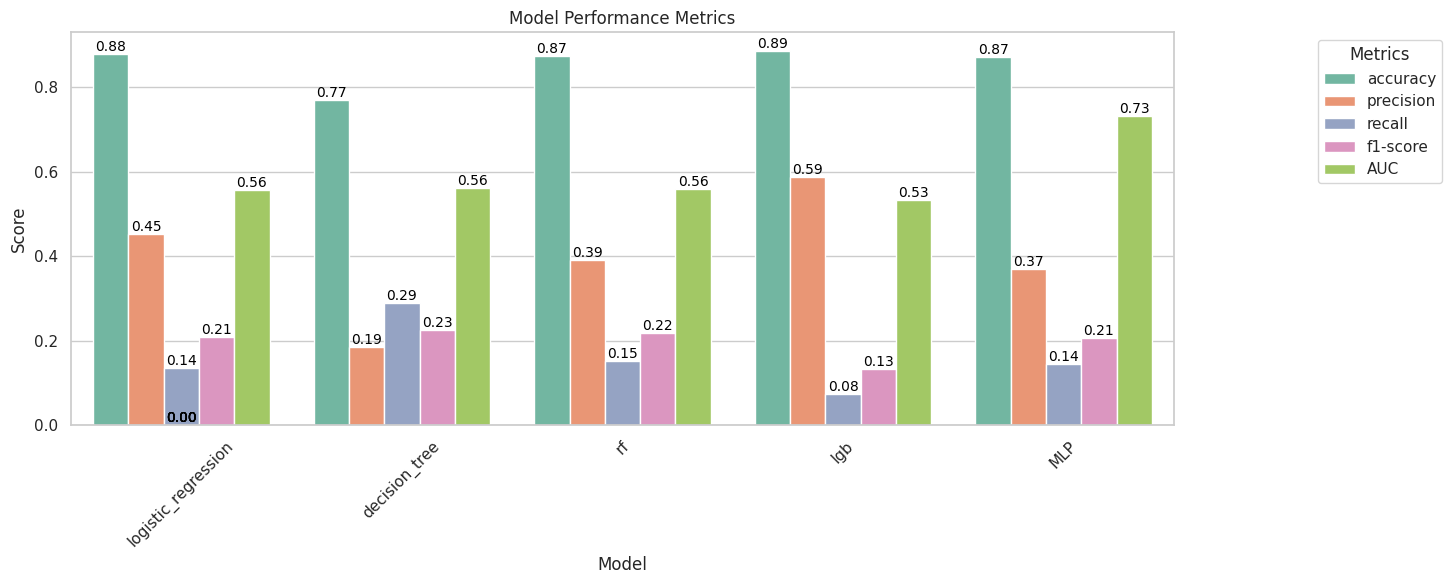

In [312]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=metrics_comparison_df.melt(id_vars="model"),
    x="model",
    y="value",
    hue="variable",
    palette="Set2",
)
ax.set(xlabel="Model", ylabel="Score")
plt.title("Model Performance Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Metrics", loc="upper right", bbox_to_anchor=(1.25, 1))

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=10,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.show()


With this, we can conclude that perhaps MLP (Neural Network) has the upper hand as it's accuracy and AUC is relatively high, while LightGBM may be better if accuracy and precision is the metric of choice. 

From these result, we would do further testing for the model chosen (in this case, LightGBM and MLP is proposed) for the requirement (robustness, stability, sensitivity)

## 5.3 Robustness (test using k-fold cross validation)

In [316]:
# In section 3, each of the models have been tested using k-fold cross validation (k=5)
cv_mean_accuracy = [
    mean_score_lr,
    mean_score_dt,
    mean_score_rf,
    mean_score_lgb,
    mean_score_mlp,
]
test_accuracy = [
    metrics_lr["accuracy"][0],
    metrics_dt["accuracy"][0],
    metrics_rf["accuracy"][0],
    metrics_lgb["accuracy"][0],
    metrics_mlp["accuracy"][0],
]

comparison_accuracy_df = pd.DataFrame(
    {
        "model": ["lr", "dt", "rf", "lgb", "mlp"],
        "test": test_accuracy,
        "cv_mean": cv_mean_accuracy,
    }
).assign(difference=lambda df: df["test"] - df["cv_mean"])
comparison_accuracy_df

model      test   cv_mean  difference
0    lr  0.880086  0.897485   -0.017399
1    dt  0.769362  0.841220   -0.071858
2    rf  0.873651  0.950747   -0.077097
3   lgb  0.886013  0.932303   -0.046291
4   mlp  0.871536  0.898605   -0.027069

Note: Most of the models have relatively consistent accuracy from the test data vs the mean accuracy from the K-fold CV with MLP and LR having the slightest edge. This shows that the models trained is able to generalize to unseen data.

## 5.4 Imbalanced Data Test - To Undersampling

In [318]:
# Check if the logistic regression model is susceptible to imbalanced data as it is nature of the data source to have imbalanced dataset
clf_imb = lgb.LGBMClassifier(**best_params_lgb, random_state=28)
# Train the model using the training data that was not resampled
clf_imb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_imb.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20721, number of negative: 158021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 178742, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115927 -> initscore=-2.031580
[LightGBM] [Info] Start training from score -2.031580


                               model  accuracy  precision    recall  f1-score  \
0  logistic_regression_non_resampled  0.885504   0.570552  0.072884  0.129256   

        AUC              false_positive_rate               true_positive_rate  
0  0.532822  [0.0, 0.00724070160920899, 1.0]  [0.0, 0.07288401253918496, 1.0]  
Confusion Matrix:
[[67183   490]
 [ 8281   651]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     67673
           1       0.57      0.07      0.13      8932

    accuracy                           0.89     76605
   macro avg       0.73      0.53      0.53     76605
weighted avg       0.85      0.89      0.84     76605



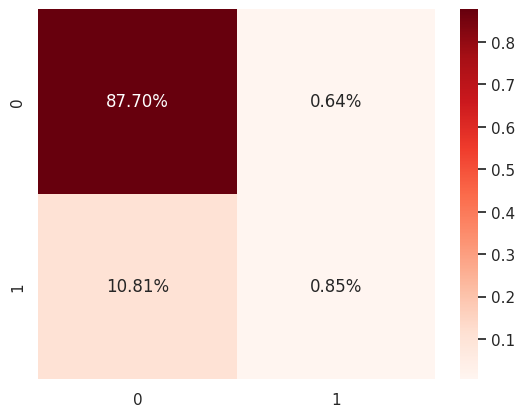

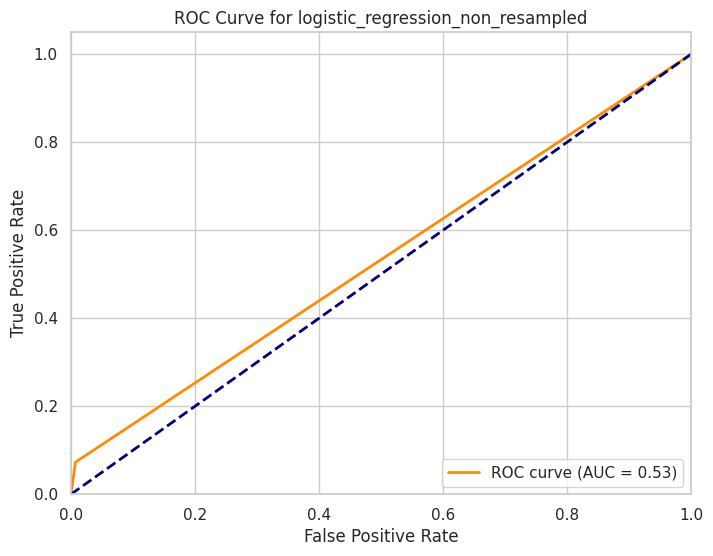

In [319]:
metrics_imb, cm_imb, cr_imb = get_metrics(
    model="logistic_regression_non_resampled", y_test=y_test, y_pred=y_pred
)

Note: From here we can observe that when we use the imbalanced dataset (X_train) the model tends to be biased towards the majority class. This is similar to when we trained with data with balanced dataset using SMOTE. 

In [341]:
# Use the cleaned dataframe before splitting into X and Y
majority_class = cleaned_df[cleaned_df['Default'] == 0]
minority_class = cleaned_df[cleaned_df['Default'] == 1]

In [342]:
# Use random undersampling
majority_undersampled = majority_class.sample(n=len(minority_class))
majority_undersampled

Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
221490 -0.033242 -0.309276   -0.117558    -0.907874        0.388474   
201271 -1.634285  1.536016    1.592465    -0.826063       -0.910478   
178829 -1.434155 -0.994953   -1.052884    -1.153306       -0.102241   
188340  1.701221  0.742878    0.609497    -0.819770       -0.535225   
159798  0.700569  0.543945   -0.644544    -0.964512        0.244146   
...          ...       ...         ...          ...             ...   
140713  0.300309  0.807708    0.644167     0.048681       -0.535225   
149119  0.967410 -0.107777   -0.042996    -1.618997       -1.487790   
221203 -1.634285 -0.598192    0.507282    -0.253389        0.128684   
248062 -0.300083  1.635315    0.715044     1.514980        1.427636   
124125  0.700569  1.096265   -1.682791     1.263255       -1.603253   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  Default  ...  \
221490       -1.343791      1.599840  0.705634  0.302222        0  ...   
201271       -1.343791      0.759027  0.705634  1.038420        0  ...   
178829        1.341937      0.276840  1.412793  1.168337        0  ...   
188340        0.446694     -0.577535 -0.001526 -0.347364        0  ...   
159798       -0.448549     -0.955751 -0.708685  0.995114        0  ...   
...                ...           ...       ...       ...      ...  ...   
140713        0.446694     -1.440951  1.412793  0.821891        0  ...   
149119       -1.343791     -1.073284  0.705634 -0.996951        0  ...   
221203       -0.448549     -1.538896 -0.001526  1.298254        0  ...   
248062        1.341937     -0.221923 -0.001526 -1.689843        0  ...   
124125       -0.448549      1.149297 -1.415845  1.428172        0  ...   

        HasMortgage_Yes  HasDependents_No  HasDependents_Yes  \
221490             True             False               True   
201271            False             False               True   
178829            False              True              False   
188340             True              True              False   
159798             True              True              False   
...                 ...               ...                ...   
140713            False              True              False   
149119             True             False               True   
221203            False              True              False   
248062            False             False               True   
124125             True             False               True   

        LoanPurpose_Auto  LoanPurpose_Business  LoanPurpose_Education  \
221490              True                 False                  False   
201271             False                 False                   True   
178829             False                 False                  False   
188340             False                 False                   True   
159798             False                  True                  False   
...                  ...                   ...                    ...   
140713             False                 False                   True   
149119             False                  True                  False   
221203              True                 False                  False   
248062             False                 False                   True   
124125             False                  True                  False   

        LoanPurpose_Home  LoanPurpose_Other  HasCoSigner_No  HasCoSigner_Yes  
221490             False              False            True            False  
201271             False              False           False             True  
178829             False               True           False             True  
188340             False              False            True            False  
159798             False              False           False             True  
...                  ...                ...             ...              ...  
140713             False              False           False             

In [344]:
balanced_df = pd.concat([majority_undersampled, minority_class], axis=0)
balanced_df

Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
221490 -0.033242 -0.309276   -0.117558    -0.907874        0.388474   
201271 -1.634285  1.536016    1.592465    -0.826063       -0.910478   
178829 -1.434155 -0.994953   -1.052884    -1.153306       -0.102241   
188340  1.701221  0.742878    0.609497    -0.819770       -0.535225   
159798  0.700569  0.543945   -0.644544    -0.964512        0.244146   
...          ...       ...         ...          ...             ...   
255310  1.434381  0.736769   -0.217204    -1.631583       -1.632118   
255324  0.433729 -1.228303   -0.264310    -1.430203       -1.228000   
255333 -1.434155 -0.947678   -1.188921    -0.184164        1.138980   
255341 -0.233372  1.216302   -0.161770     0.797563       -0.621822   
255343 -0.767053 -0.783984    0.879724    -0.398130       -1.314597   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  Default  ...  \
221490       -1.343791      1.599840  0.705634  0.302222        0  ...   
201271       -1.343791      0.759027  0.705634  1.038420        0  ...   
178829        1.341937      0.276840  1.412793  1.168337        0  ...   
188340        0.446694     -0.577535 -0.001526 -0.347364        0  ...   
159798       -0.448549     -0.955751 -0.708685  0.995114        0  ...   
...                ...           ...       ...       ...      ...  ...   
255310        0.446694      1.006147 -0.001526  0.562057        1  ...   
255324        1.341937     -0.259593 -0.708685 -0.130836        1  ...   
255333       -1.343791      1.260802 -1.415845  0.085693        1  ...   
255341        0.446694     -0.539865 -0.708685 -1.170174        1  ...   
255343       -0.448549     -0.292744 -0.708685 -1.256785        1  ...   

        HasMortgage_Yes  HasDependents_No  HasDependents_Yes  \
221490             True             False               True   
201271            False             False               True   
178829            False              True              False   
188340             True              True              False   
159798             True              True              False   
...                 ...               ...                ...   
255310             True             False               True   
255324             True              True              False   
255333             True             False               True   
255341             True              True              False   
255343            False              True              False   

        LoanPurpose_Auto  LoanPurpose_Business  LoanPurpose_Education  \
221490              True                 False                  False   
201271             False                 False                   True   
178829             False                 False                  False   
188340             False                 False                   True   
159798             False                  True                  False   
...                  ...                   ...                    ...   
255310              True                 False                  False   
255324             False                  True                  False   
255333             False                 False                   True   
255341             False                 False                  False   
255343             False                 False                  False   

        LoanPurpose_Home  LoanPurpose_Other  HasCoSigner_No  HasCoSigner_Yes  
221490             False              False            True            False  
201271             False              False           False             True  
178829             False               True           False             True  
188340             False              False            True            False  
159798             False              False           False             True  
...                  ...                ...             ...              ...  
255310             False              False            True            F

In [345]:
# Set Independent and Dependent Variables
X_undersampled = balanced_df.drop("Default", axis=1)
y_undersampled = balanced_df["Default"]

In [346]:
# Split to training, validation and test dataset ('re using 70/30 - train/test)
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_undersampled, y_undersampled, test_size=0.3, random_state=28
)

### 5.4.1 Imbalanced Data Set - LGBM

In [371]:
# Check if the LGBM model is susceptible to imbalanced data as it is nature of the data source to have imbalanced dataset
clf_imb = lgb.LGBMClassifier(**best_params_lgb, random_state=28)
# Train the model using the training data that was not resampled
clf_imb.fit(X_train_us, y_train_us)

# Make predictions on the test data
y_pred_lgb_us = clf_imb.predict(X_test_us)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20782, number of negative: 20732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 41514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500602 -> initscore=0.002409
[LightGBM] [Info] Start training from score 0.002409


              model  accuracy  precision    recall  f1-score       AUC  \
0  lgb_undersampled  0.679294   0.675658  0.686168  0.680872  0.679313   

              false_positive_rate              true_positive_rate  
0  [0.0, 0.3275417554085865, 1.0]  [0.0, 0.6861684139330403, 1.0]  
Confusion Matrix:
[[5999 2922]
 [2784 6087]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      8921
           1       0.68      0.69      0.68      8871

    accuracy                           0.68     17792
   macro avg       0.68      0.68      0.68     17792
weighted avg       0.68      0.68      0.68     17792



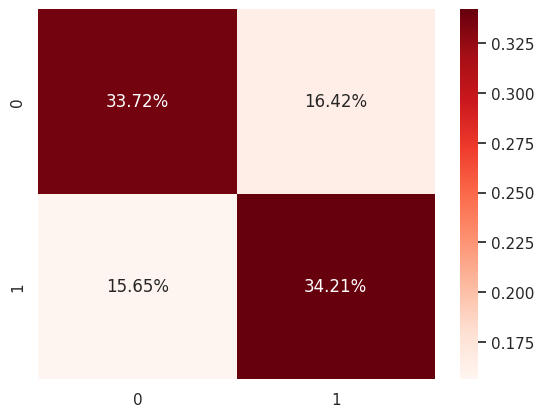

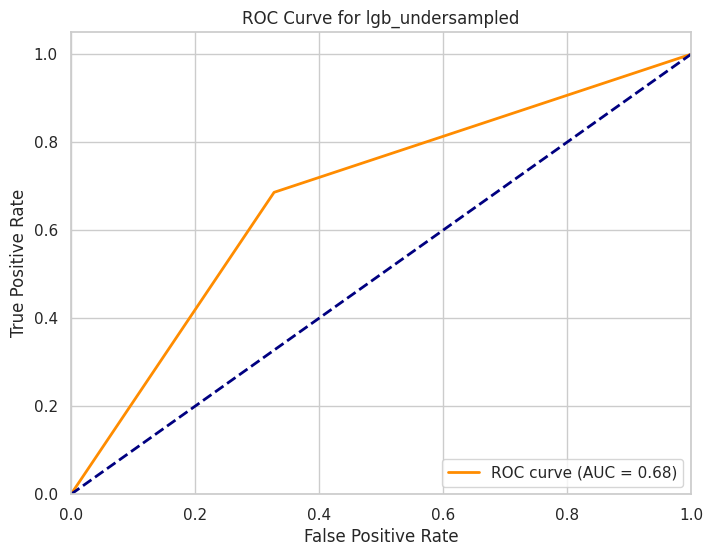

In [372]:
metrics_imb, cm_imb, cr_imb = get_metrics(
    model="lgb_undersampled", y_test=y_test_us, y_pred=y_pred_lgb_us
)

Note: We can see that metrics changed drastically with significantly lesser data points (50k+ with undersampling instead of 300k+).

Accuracy Decrease:
- Undersampling reduces the number of majority class instances to balance the class distribution. As a result, the model has fewer non-default (majority class) instances to make correct predictions on.
- Since accuracy is the ratio of correctly predicted instances to the total number of instances, the decrease in the number of majority class instances can lead to a decrease in accuracy.

Recall Increase:
- Recall (sensitivity or true positive rate) measures the proportion of true positive predictions among all actual positive instances (defaults).
- Undersampling effectively increases the focus on the minority class (defaults) because it reduces the dominance of the majority class. With a balanced dataset, the model is more likely to correctly identify minority class instances.
- This results in a significant increase in recall because the model is better at capturing true positives (defaults), which is one of the primary goals when dealing with imbalanced datasets and critical tasks like loan default prediction.

Precision and F1-Score Trade-off:
- While recall increases significantly due to undersampling, there is typically a trade-off with precision. Precision measures the proportion of true positive predictions among all positive predictions.
- Undersampling may increase recall by allowing the model to capture more true positives, but it can also lead to more false positives (misclassifying non-defaults as defaults), reducing precision.
- As a result, the F1-score, which is the harmonic mean of precision and recall, may show a mixed response, depending on the specific trade-off between precision and recall.

AUC (Area Under the ROC Curve):
- AUC measures the model's ability to distinguish between positive and negative classes. When using undersampling, the ROC curve may change because the model's behavior in classifying defaults and non-defaults is affected. The AUC value reflects this change.

### 5.4.2 Imbalanced Data Set - MLP

In [ ]:
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	# Input_dim = 31 features
	model.add(Dense(12, input_dim=31, activation="relu"))
	model.add(Dense(8, activation="relu"))
	model.add(Dense(1, activation="sigmoid"))
	# Compile model
	model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
	return model

model_mlp = create_model()

# Create model using best hyperparameters
best_model_mlp = KerasClassifier(model=model_mlp, epochs=30, batch_size=128, verbose=0)

In [380]:
input_shape_us = X_train_us.shape[1]
# Number of classes (binary classification: 0 for not defaulted, 1 for defaulted)
num_classes = 2

# Define your MLP model using Keras
model_mlp_us = keras.Sequential([
    layers.Input(shape=(input_shape_us,)),  # Define the input shape
    layers.Dense(128, activation="relu"),  # Add a hidden layer with 128 units and ReLU activation
    layers.Dense(64, activation="relu"),   # Add another hidden layer with 64 units and ReLU activation
    layers.Dense(num_classes, activation="softmax")  # Output layer with the number of classes and softmax activation
])

# Compile the model
model_mlp_us.compile(optimizer="adam",  # You can use other optimizers as well
              loss="sparse_categorical_crossentropy",  # For classification tasks
              metrics=["accuracy"])

# Train the model on your training data
model_mlp_us.fit(X_train_us.apply(lambda x: x.astype("float32")), y_train_us, epochs=30, batch_size=128) # best params 

# Make predictions on the test data
y_pred_keras_us = model_mlp_us.predict(X_test_us.apply(lambda x: x.astype("float32")))

# Convert probabilities to class labels
y_pred_keras_labels_us = np.argmax(y_pred_keras_us, axis=-1)

Epoch 1/30


325/325 [==============================] - 1s 3ms/step - loss: 0.5988 - accuracy: 0.6778
Epoch 2/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5859 - accuracy: 0.6893
Epoch 3/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5820 - accuracy: 0.6922
Epoch 4/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5797 - accuracy: 0.6924
Epoch 5/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5779 - accuracy: 0.6957
Epoch 6/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5754 - accuracy: 0.6968
Epoch 7/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5734 - accuracy: 0.6988
Epoch 8/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5710 - accuracy: 0.7012
Epoch 9/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5679 - accuracy: 0.7040
Epoch 10/30
325/325 [==============================] - 1s 3ms/step - loss: 0.5647 - accuracy: 0.7067
Epoch 11/3

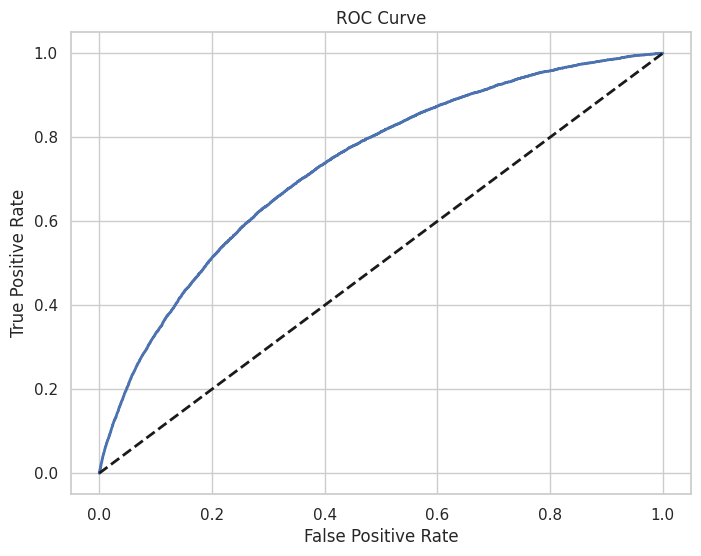

Accuracy: 0.6500674460431655
Recall: 0.6849284184421147
F1 Score: 0.6612253781695505
AUC-ROC Score: 0.7316406098598176


In [381]:
# Convert it to a 1D array with binary labels (0 or 1)
y_test_binary_us = y_test_us.array # Assuming that the second column (index 1) contains the positive class

# Calculate metrics using y_test_binary
accuracy = accuracy_score(y_test_binary_us, y_pred_keras_labels_us)
precision = precision_score(y_test_binary_us, y_pred_keras_labels_us)
recall = recall_score(y_test_binary_us, y_pred_keras_labels_us)
f1 = f1_score(y_test_binary_us, y_pred_keras_labels_us)

# Calculate AUC-ROC score and plot ROC curve using y_pred_keras[:, 1]
roc_auc = roc_auc_score(y_test_binary, y_pred_keras[:, 1])
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_keras[:, 1])

metrics_mlp_us = pd.DataFrame(
        {
            "model": "MLP_undersampled",
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1-score": [f1],
            "AUC": [roc_auc],
            "false_positive_rate": [fpr],
            "true_positive_rate": [tpr],
        }
    )

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='45-degree line')  # Adding the 45-degree line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the calculated metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)


In [382]:
pd.concat([metrics_mlp_us, metrics_mlp])

model  accuracy  precision    recall  f1-score       AUC  \
0  MLP_undersampled  0.650067   0.639108  0.684928  0.661225  0.731641   
0               MLP  0.871536   0.369808  0.144536  0.207840  0.731641   

                                 false_positive_rate  \
0  [0.0, 1.4776942059610185e-05, 8.86616523576611...   
0  [0.0, 1.4776942059610185e-05, 8.86616523576611...   

                                  true_positive_rate  
0  [0.0, 0.0, 0.0, 0.0002239140170174653, 0.00022...  
0  [0.0, 0.0, 0.0, 0.0002239140170174653, 0.00022...

Note: 
Similarly with LGBM, it seems like the model (MLP) will have reduced accuracy in return to have better precision, recall and f1-score. 

In summary, undersampling is effective at increasing recall by reducing the dominance of the majority class, making the model more sensitive to the minority class (defaults). However, it often comes at the cost of reduced accuracy and a potential trade-off between precision and recall. The choice of which rebalancing technique to use (undersampling, oversampling, SMOTE, etc.) should align with the specific business requirements and objectives, such as whether correctly identifying defaults is more critical than overall accuracy.
- In this case, it is crucial to be able to identify on the minority class (defaults) as they have bigger impact than false negatives. While this comes at an expense of losing information through undersampling, this may be justified for a better model. 

## 5.5 Simplying the Model - Feature Engineering

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20782, number of negative: 20732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 41514, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500602 -> initscore=0.002409
[LightGBM] [Info] Start training from score 0.002409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

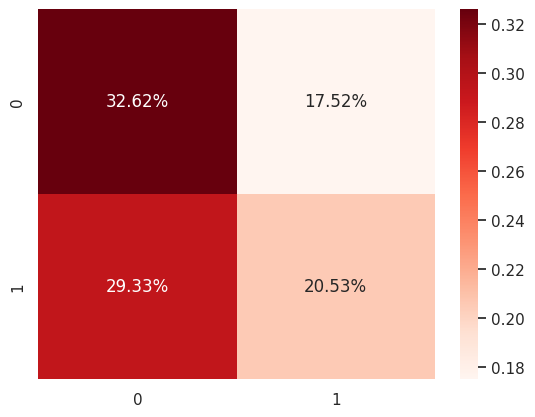

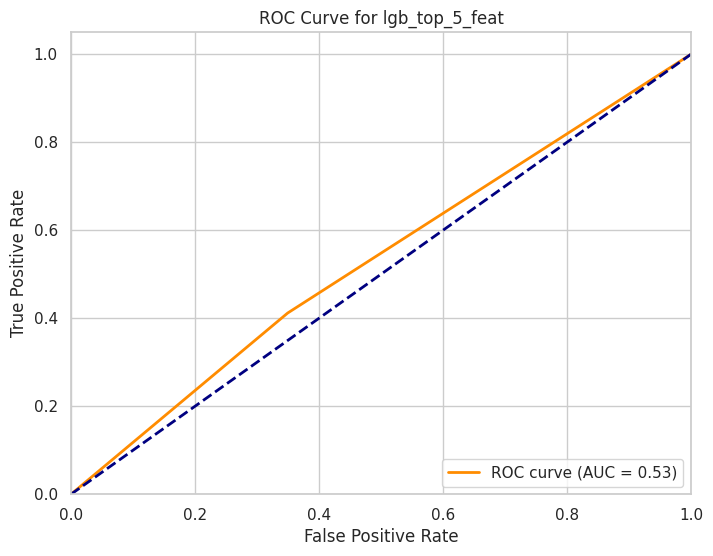

In [362]:
# Check if the logistic regression model performance when using feature engineering (only use top 5 features from feature importance)
clf_top5 = lgb.LGBMClassifier(**best_params_lgb, random_state=28)

# Train the MLP classifier on the training data
clf_top5.fit(X_train_us.loc[:, top_5_feat_lr], y_train_us)

y_pred = clf_top5.predict(X_test_us.loc[:, top_5_feat_lr])

metrics_top5, cm_top5, cr_top5 = get_metrics(
    model="lgb_top_5_feat", y_test=y_test_us, y_pred=y_pred
)

In [374]:
pd.DataFrame(
    {
        "model": ["lgb_undersampled", "lgb_us_top_5_feat_only"],
        "accuracy": [accuracy_score(y_test_us, y_pred_lgb_us), accuracy_score(y_test_us, y_pred)],
        "precision": [
            precision_score(y_test_us, y_pred_lgb_us),
            precision_score(y_test_us, y_pred),
        ],
        "recall": [recall_score(y_test_us, y_pred_lgb_us), recall_score(y_test_us, y_pred)],
        "f1_score": [f1_score(y_test_us, y_pred_lgb_us), f1_score(y_test_us, y_pred)],
        "auc": [roc_auc_score(y_test_us, y_pred_lgb_us), roc_auc_score(y_test_us, y_pred)],
    }
)

model  accuracy  precision    recall  f1_score       auc
0        lgb_undersampled  0.679294   0.675658  0.686168  0.680872  0.679313
1  lgb_us_top_5_feat_only  0.531531   0.539586  0.411791  0.467106  0.531195

Note: This suggests that the feature engineering or selection choices made in using the top 5 features might not be as effective in capturing the important patterns in the data, especially in identifying defaults.

## 5.6 Sensitivity Analysis - Pertubation Test

In [418]:
y_test_us

221996    1
216511    0
118577    0
19224     0
214898    1
         ..
102700    0
181704    1
244606    1
167799    0
168177    1
Name: Default, Length: 17792, dtype: int64

In [430]:
# Perturb the dataset by adding small random noise
perturbation_scale = 0.01
num_iterations = 300  # Adjust the number of iterations based on your needs
accuracy_pertubed = []
accuracy_difference_with_baseline = []
recall_pertubed = []
recall_difference_with_baseline = []

clf_ = LogisticRegression(**best_params_lr, max_iter=2000)
clf_.fit(X_train_us, y_train_us)

for i in range(num_iterations):
    # Perturb the dataset
    perturbed_X = X_test_us.copy()
    perturbed_X += np.random.normal(0, perturbation_scale, size=perturbed_X.shape)

    # Make predictions using pertubed X
    perturbed_preds = clf_.predict(perturbed_X)
    # Calculate accuracy using perturbed predictions
    accuracy_ = accuracy_score(y_test_us, perturbed_preds)
    baseline_accuracy = metrics_imb["accuracy"][0]

    accuracy_pertubed.append(accuracy_)
    accuracy_difference_with_baseline.append(accuracy_ - baseline_accuracy)

In [431]:
pd.DataFrame(
    {
        "accuracy_pertubed": accuracy_pertubed,
        "accuracy_diff_with_baseline": accuracy_difference_with_baseline,
    }
).mean()

accuracy_pertubed              0.679135
accuracy_diff_with_baseline   -0.000159
dtype: float64

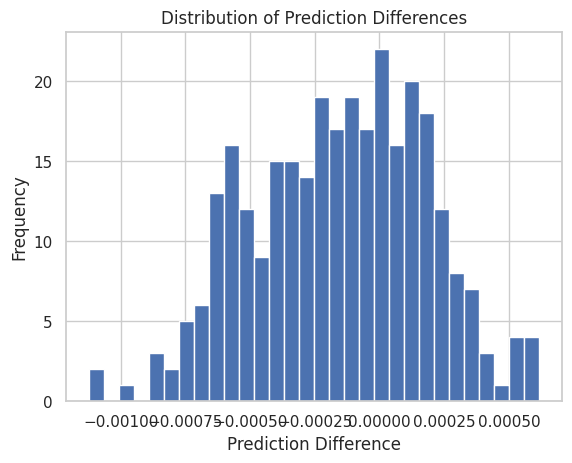

In [432]:
# Visualize the distribution of the accuracy difference with baseline (e.g., using a histogram)
plt.hist(accuracy_difference_with_baseline, bins=30)
plt.xlabel("Prediction Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Differences")
plt.show()

Note: The model (LGBM) seems relatively unstable despite pertubing the data by 1% (small) noise, it may suggest that the model is susceptible to minor variations in the input (where the accuracy is signficantly reduced to the baseline accuracy)

In [433]:
# Perturb the dataset by adding small random noise
perturbation_scale = 0.01
num_iterations = 300  # Adjust the number of iterations based on your needs
accuracy_pertubed = []
accuracy_difference_with_baseline = []
recall_pertubed = []
recall_difference_with_baseline = []

# Set the input shape
input_shape_us = X_train_us.shape[1]
# Number of classes (binary classification: 0 for not defaulted, 1 for defaulted)
num_classes = 2

# Define your MLP model using Keras
clf_ = keras.Sequential([
    layers.Input(shape=(input_shape_us,)),  # Define the input shape
    layers.Dense(128, activation="relu"),  # Add a hidden layer with 128 units and ReLU activation
    layers.Dense(64, activation="relu"),   # Add another hidden layer with 64 units and ReLU activation
    layers.Dense(num_classes, activation="softmax")  # Output layer with the number of classes and softmax activation
])

# Compile the model
clf_.compile(optimizer="adam",  # You can use other optimizers as well
              loss="sparse_categorical_crossentropy",  # For classification tasks
              metrics=["accuracy"])

# Train the model on your training data
clf_.fit(X_train_us.apply(lambda x: x.astype("float32")), y_train_us, epochs=30, batch_size=128)

# Make predictions on the test data
y_pred_baseline = clf_.predict(X_test_us.apply(lambda x: x.astype("float32")))

# Convert probabilities to class labels
y_pred_baseline_labels = np.argmax(y_pred_baseline, axis=-1)

for i in range(num_iterations):
    # Perturb the dataset
    perturbed_X = X_test_us.copy()
    perturbed_X += np.random.normal(0, perturbation_scale, size=perturbed_X.shape)

    # Make predictions using pertubed X
    perturbed_preds = clf_.predict(perturbed_X.apply(lambda x: x.astype("float32")))
    # Convert probabilities to class labels
    perturbed_preds_labels = np.argmax(perturbed_preds, axis=-1)

    # Calculate accuracy using perturbed predictions
    accuracy_ = accuracy_score(y_test_us.array, perturbed_preds_labels)
    baseline_accuracy = metrics_mlp_us["accuracy"][0]

    accuracy_pertubed.append(accuracy_)
    accuracy_difference_with_baseline.append(accuracy_ - baseline_accuracy)

Epoch 1/30


325/325 [==============================] - 1s 3ms/step - loss: 0.5991 - accuracy: 0.6768
Epoch 2/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5864 - accuracy: 0.6901
Epoch 3/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5828 - accuracy: 0.6926
Epoch 4/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5807 - accuracy: 0.6923
Epoch 5/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5782 - accuracy: 0.6950
Epoch 6/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5758 - accuracy: 0.6990
Epoch 7/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5736 - accuracy: 0.6990
Epoch 8/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5714 - accuracy: 0.7018
Epoch 9/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5691 - accuracy: 0.7026
Epoch 10/30
325/325 [==============================] - 1s 2ms/step - loss: 0.5660 - accuracy: 0.7052
Epoch 11/3

In [436]:
pd.DataFrame(
    {
        "accuracy_pertubed": accuracy_pertubed,
        "accuracy_diff_with_baseline": accuracy_difference_with_baseline,
    }
).mean()

accuracy_pertubed              0.648850
accuracy_diff_with_baseline   -0.001218
dtype: float64

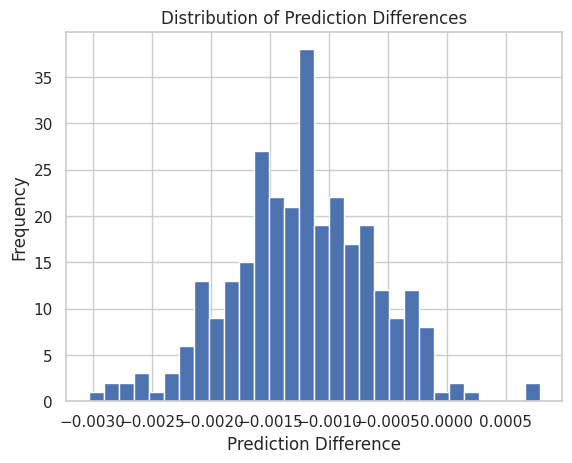

In [437]:
# Visualize the distribution of the accuracy difference with baseline (e.g., using a histogram)
plt.hist(accuracy_difference_with_baseline, bins=30)
plt.xlabel("Prediction Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Differences")
plt.show()

Note: The models (LGBM & MLP) seems relatively stable despite pertubing the data by 1% (small) noise, it may suggest that the model is robust to minor variations in the input and may not be highly sensitive to small changes in the data (where the accuracy remain close to the baseline accuracy)

## 5.7 Performance Cost

In [440]:
# Identify the time required for model fitting as this affects performance cost
model_timings = {}

# Record the timing for each model fit
for model_name, model in best_models.items():
    X_training = X_train
    start_time = time.time()

    model.fit(X_resampled, y_resampled)

    end_time = time.time()
    elapsed_time = end_time - start_time

    model_timings[model_name] = elapsed_time

for model_name, elapsed_time in model_timings.items():
    print(f"Model {model_name}: Time elapsed = {elapsed_time:.2f} seconds")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 158021, number of negative: 158021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 316042, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model lr: Time elapsed = 6.61 seconds
Model dt: Time elapsed = 13.27 seconds
Model random_forest: Time elapsed = 220.67 seconds
Model lightgbm: Time elapsed = 6.79 seconds
Model mlp: Time elapsed = 182.98 seconds


## Summary:
The models are tested and evaluated for robustness, stability and sensitivity:
1. Interpretability
    - All of the chosen models are able to provide feature/permutation importance for better interpretability.
    - Numerical variables indicators are significant features for predicting loan default such as age, income, interest rate, debt-to-income ratio, payment-to-income ratio.
    - Other significant categorical variables include education, employment type, marital status and purpose of the loan.
2. Metrics comparison (for model selection)
    - Accuracy is important, hover Recall and Area Under Curve (AUC) is also considered as we would like to understand the model's performance with regards to false positives and false negatives (which will affect business cost)
    - LightGBM / MLP is chosen based on the metrics as it provides a balance beten the selected metrics (decent accuracy, best recall and best AUC score).
3. Robustness (using k-fold cross-validation) - testing model's performance is consistent across different data splits
    - Logistic Regression seems to be consistent one here with their mean accuracy from CV is relatively similar with the accuracy using test data. (<1% difference)
4. Imbalanced data
    - Both LightGBM and MLP seems to be sensitive to imbalanced data, as the Recall significantly drops when using imbalanced data (even with oversampling with SMOTE); despite having higher accuracy.
    - Suggestion: Undersampling may be a better method as it does better in F1 Score but will lose information in the dataset. Can consider other methods for balancing the data.
5. Simplifying the model by feature engineering (choosing top 5 features)
    - By making the model more simplified, it seems like the accuracy greatly reduced. More testing is required to identify better feature (feature engineering)
6. Sensitivity analysis by pertubation test
    - Introducing 1% noise using pertubation in the input resulted in an average reduction of <1% accuracy compared to the baseline accuracy. This may suggest that the selected models are relatively stable and are not highly sensitive to small changes/variations in the data
7. Performance - Speed
    - LightGBM and Decision Tree takes the shortest time to fit, with Random Forest and MLP having significantly higher time to fit (>180s).

Final outcome: It seems like MLP/LightGBM would be the suitable choice of modelling given the evaluation; With decent accuracy and the other metrics such as Recall, F1-score and AUC makes it a better choice given the trade-off of accuracy for these other metrics that may be useful for the business context. It has also passed other tests for robustness, stability and sensitivity which is part of the requirement of this task.